In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-24 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5,5,10,10,10,15,18,18,29,32,32,32,32,32,40,43,54,99,112,131,135,150,166,179
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52,67,76,89,99,104,116,131,154,165,182,197,217,232,248,251,277,283,302,314,327,345,356,385
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46,61,61,62,90,90,90,113,237,347,405,460,591,601,691,708,783,846,894,1047,1099,1152,1204,1355
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10,10,10,16,21,26,31,39,52,58,71,71,128,128,128,169,169,191,205,235,248,282,309,333
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,4,4,4,5,5,5,5,6,6,6,6,6,6


In [7]:
list(covid19.augment_time_series_from_daily_snapshots_date_range)

[]

In [8]:
# ldf = covid19.augment_time_series_from_daily_snapshots(covid19.augment_time_series_from_daily_snapshots_date_range)
# ldf

In [9]:
# ldf = covid19.augment_time_series_from_daily_snapshots(covid19.augment_time_series_from_daily_snapshots_date_range)[0][['Province/State', 'Country/Region', '3/15/20']]
# # # ldf[ldf['3/14/20'] < 0]
# ldf[ldf['Country/Region'] == 'Spain']

In [10]:
# ldf_confirmed, ldf_recovered, ldf_death, columns, selector = covid19.get_cases_by_region()

In [11]:
df = covid19.get_cases_by_region()
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-19,142422,88000,4418,1974,2600,115
2020-04-20,143150,91500,4515,728,3500,97
2020-04-21,144759,95200,4738,1609,3700,223
2020-04-22,147508,99400,5018,2749,4200,280
2020-04-23,150012,103300,5269,2504,3900,251


In [12]:
df = covid19.get_cases_by_region(region='China')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-19,83805,77690,4636,18,76,0
2020-04-20,83817,77745,4636,12,55,0
2020-04-21,83853,77799,4636,36,54,0
2020-04-22,83868,77861,4636,15,62,0
2020-04-23,83884,77983,4636,16,122,0


In [13]:
# df = covid19.get_cases_by_region(region='Switzerland')
# df

In [14]:
# df = covid19.get_cases_by_region(region='US')
# df

* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [15]:
cbr_germany = covid19.CasesByRegion('Germany')
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-19,142422,88000,4418,1974,2600,115
2020-04-20,143150,91500,4515,728,3500,97
2020-04-21,144759,95200,4738,1609,3700,223
2020-04-22,147508,99400,5018,2749,4200,280
2020-04-23,150012,103300,5269,2504,3900,251


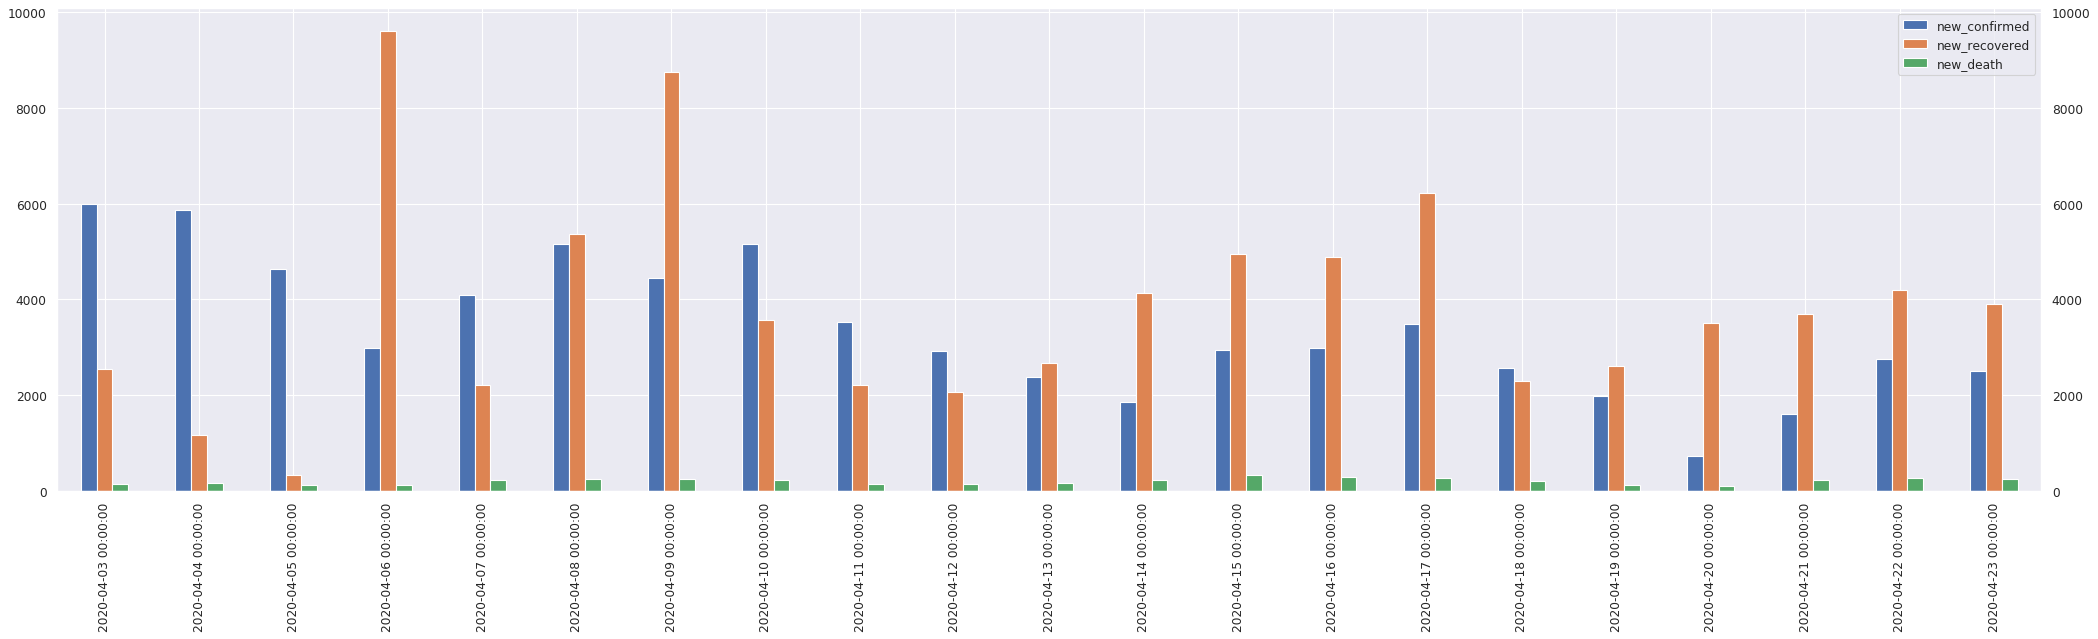

In [16]:
cbr_germany.plot_daily_stats()

135.0 184.0


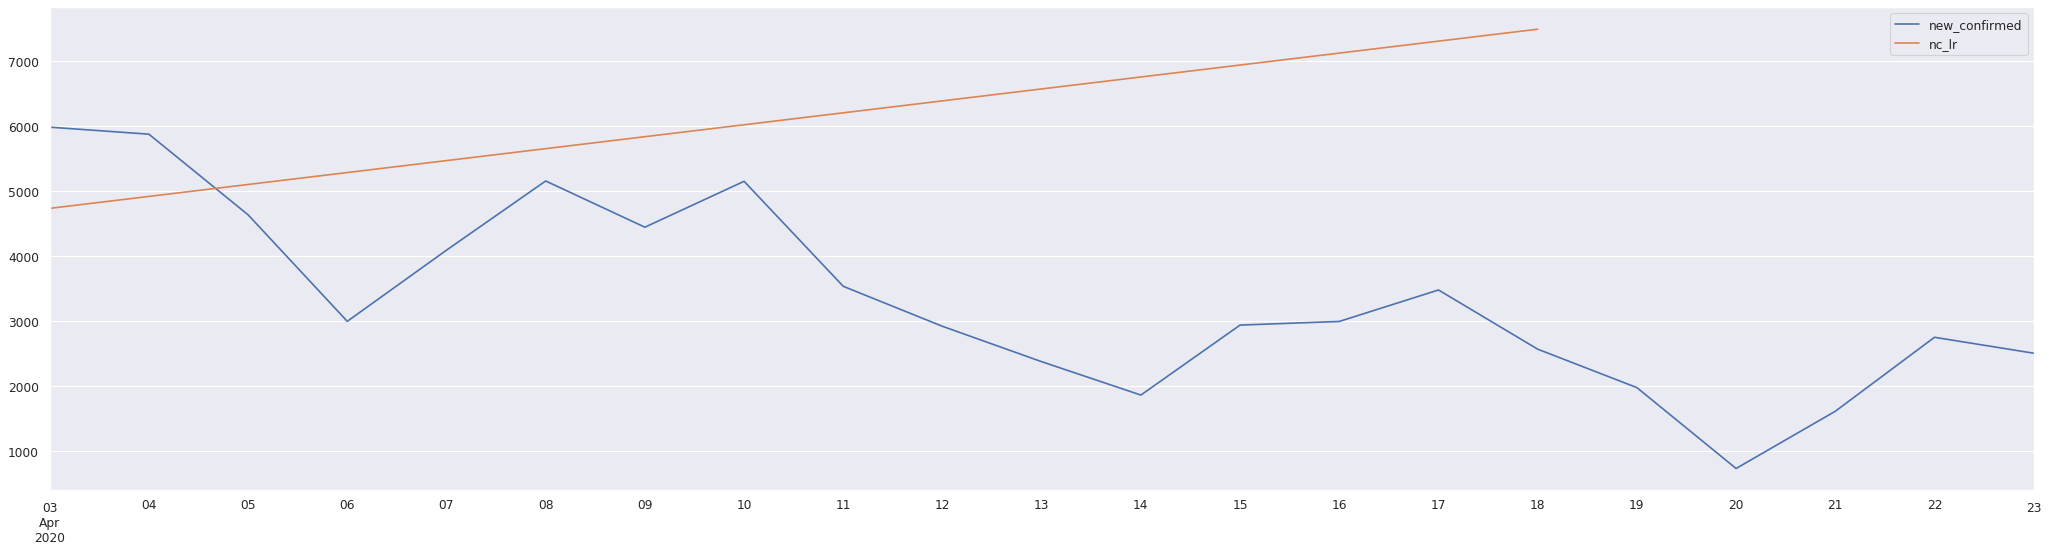

In [17]:
date_range = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime('2020-03-16'))
cbr_germany_new_confirmed_df = cbr_germany.df.loc[date_range,['new_confirmed']]
x = np.arange(len(cbr_germany_new_confirmed_df) * 1.0)

regressor = sklearn.linear_model.LinearRegression()  
regressor.fit(x.reshape(-1, 1), cbr_germany_new_confirmed_df.new_confirmed.values.reshape(-1, 1) * 1.0)

last_day = cbr_germany.df.index[-1]
ldr = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime(last_day))
ldr1 = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime('2020-04-18'))
x = np.arange(len(ldr1) * 1.0)

y = regressor.intercept_[0] + regressor.coef_[0,0]*x
cbr_germany_new_confirmed_lr_df = pd.DataFrame(y.reshape(-1,1),index=ldr1, columns=['nc_lr'])

ldf = pd.concat([cbr_germany.df, cbr_germany_new_confirmed_lr_df], axis=1)
ldf.loc[:] = ldf.values * 1.0
ldf = ldf.loc[last_day + datetime.timedelta(days=-20):,['new_confirmed', 'nc_lr']]
fig = plt.figure(figsize=(32, 8), dpi=80, facecolor='w', edgecolor='k')
ax  = plt.subplot(1, 1, 1)
ldf.plot(ax=ax)
print(regressor.intercept_[0].round(2), regressor.coef_[0,0].round(2))

[COVID-19-Pandemie#Deutschland](https://de.wikipedia.org/wiki/COVID-19-Pandemie#Deutschland):

> Am 22. März 2020 einigten sich Bund und Länder auf ein „umfassendes Kontaktverbot“, statt weitergehende Ausgangssperren zu beschließen.


> Roughly 2020-04-21 the taken actions show clear effect; roughly 4.5 weeks later.

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate  | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-21 |  92845 | 0.057 | - |
| 2020-04-03 | 2020-04-23 |  99774 | 0.054 | - |
| 2020-04-04 | 2020-04-25 | 107193 | 0.051 | - |
| 2020-04-05 | 2020-04-27 | 114511 | 0.049 | - |
| 2020-04-06 | 2020-04-29 | 119618 | 0.045 | - |
| 2020-04-07 | 2020-04-29 | 121354 | 0.039 | - |
| 2020-04-08 | 2020-04-30 | 123011 | 0.035 | - |
| 2020-04-09 | 2020-04-30 | 125833 | 0.031 | - |
| 2020-04-10 | - | - | 0.049 | 4820 |
| 2020-04-11 | - | - | 0.042 | 4739 |
| 2020-04-12 | - | - | 0.040 | 4570 |
| 2020-04-13 | - | - | 0.036 | 4300 |
| 2020-04-14 | - | - | 0.033 | 3927 |
| 2020-04-15 | - | - | 0.029 | 3451 |
| 2020-04-16 | - | - | 0.026 | 3086 |
| 2020-04-17 | - | - | 0.024 | 2845 |
| 2020-04-19 | - | - | 0.021 | 2666 |
| 2020-04-20 | - | - | 0.020 | 2554 |
| 2020-04-21 | - | - | 0.018 | 2356 |
| 2020-04-24 | - | - | 0.015 | 2043 |

sigmoid+linear 2020-06-01 00:00:00 [100370.814709        0.18546437     -3.89115785  11015.4721709 ] 0.014923513242924624 2042.9775866206162


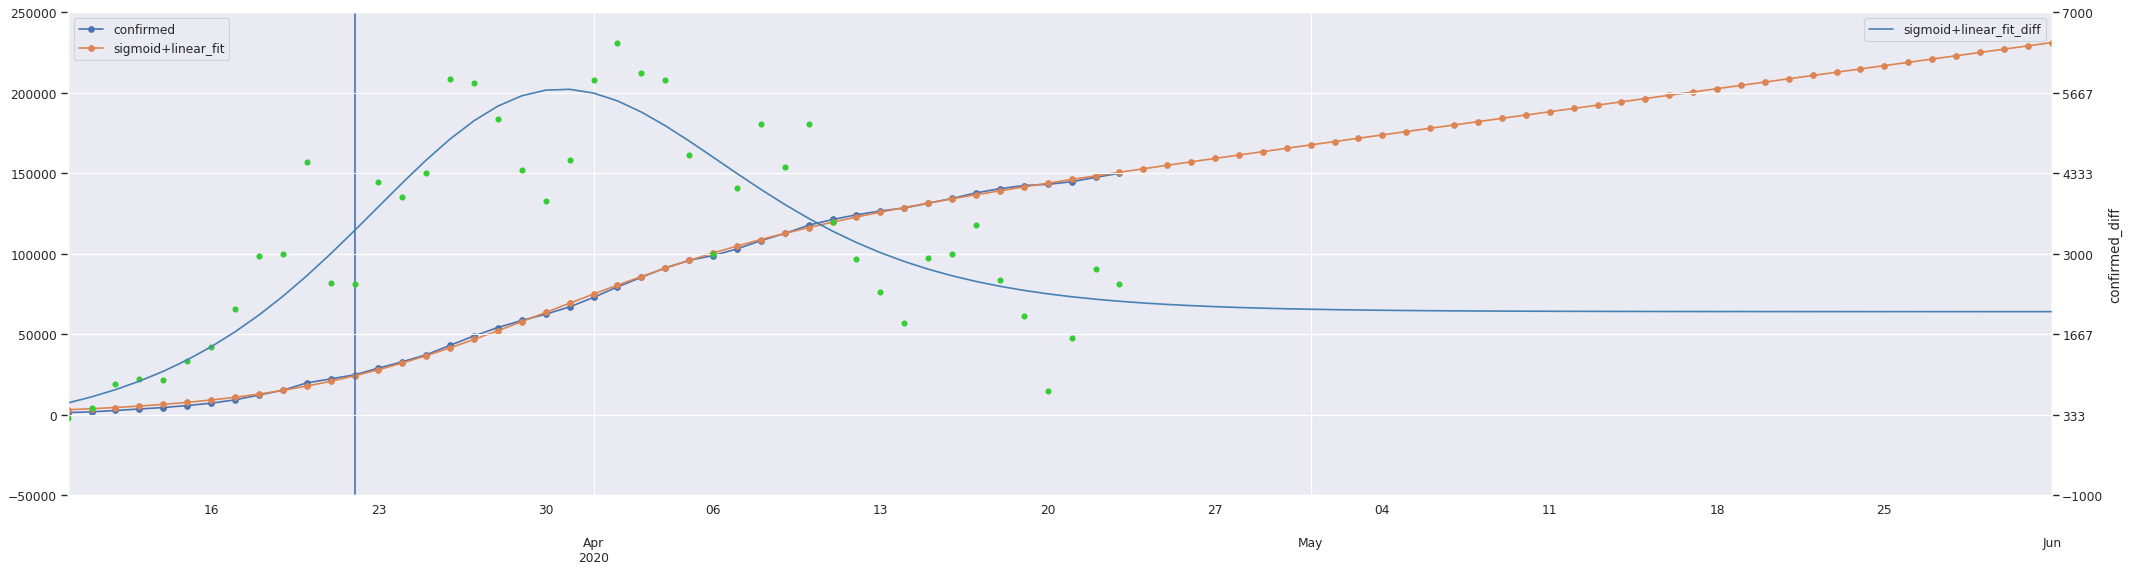

In [18]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [19]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid+linear_fit_diff
max,5723.918114


In [20]:
lds = ldf['confirmed']
idx = lds.index.get_loc(lds.last_valid_index())
lds.iloc[idx] - lds.iloc[idx-1]

2504.0

sigmoid+linear 2020-05-28 00:00:00 [95355.81898404     1.35650825    -3.97437114 11682.49100764] 0.1564456498582658 15847.395457049402 0.020981539311362152 2263.913636721343


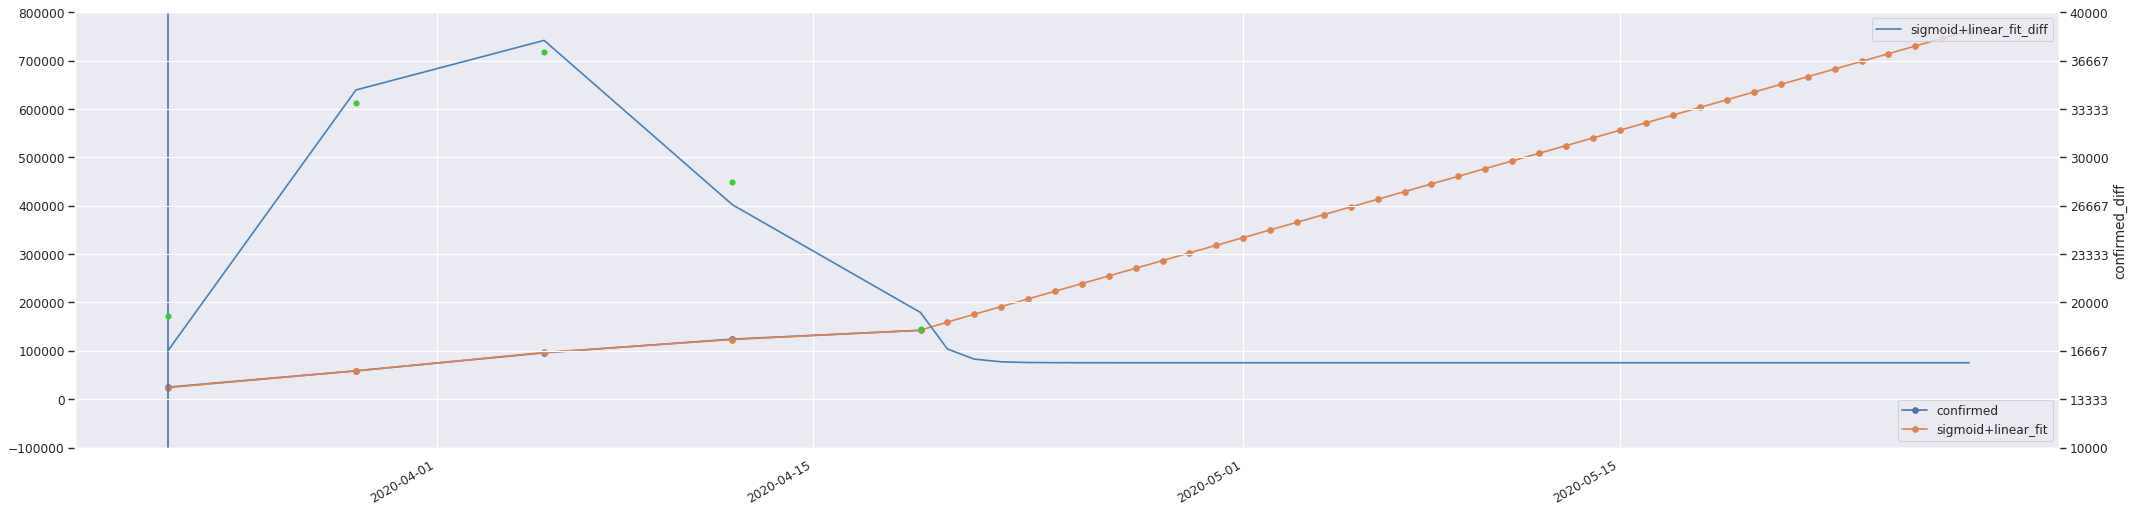

In [21]:
last_date_for_week_aggregation = cbr_germany.df.index[-1] + relativedelta.relativedelta(weekday=relativedelta.SU(-1))
ldf = cbr_germany.df[(cbr_germany.df.index >= first_date) & (cbr_germany.df.index <= last_date_for_week_aggregation)][['confirmed']]
in_df = ldf.resample('W').agg(pd.Series.max, skipna=False) #.sum(skipna=False) # 

ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add, in_df=in_df)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate, np.power(1.0 + lgrowthRate,1/7) - 1.0, steady_state_rate / 7)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [22]:
# ldf.round(2)

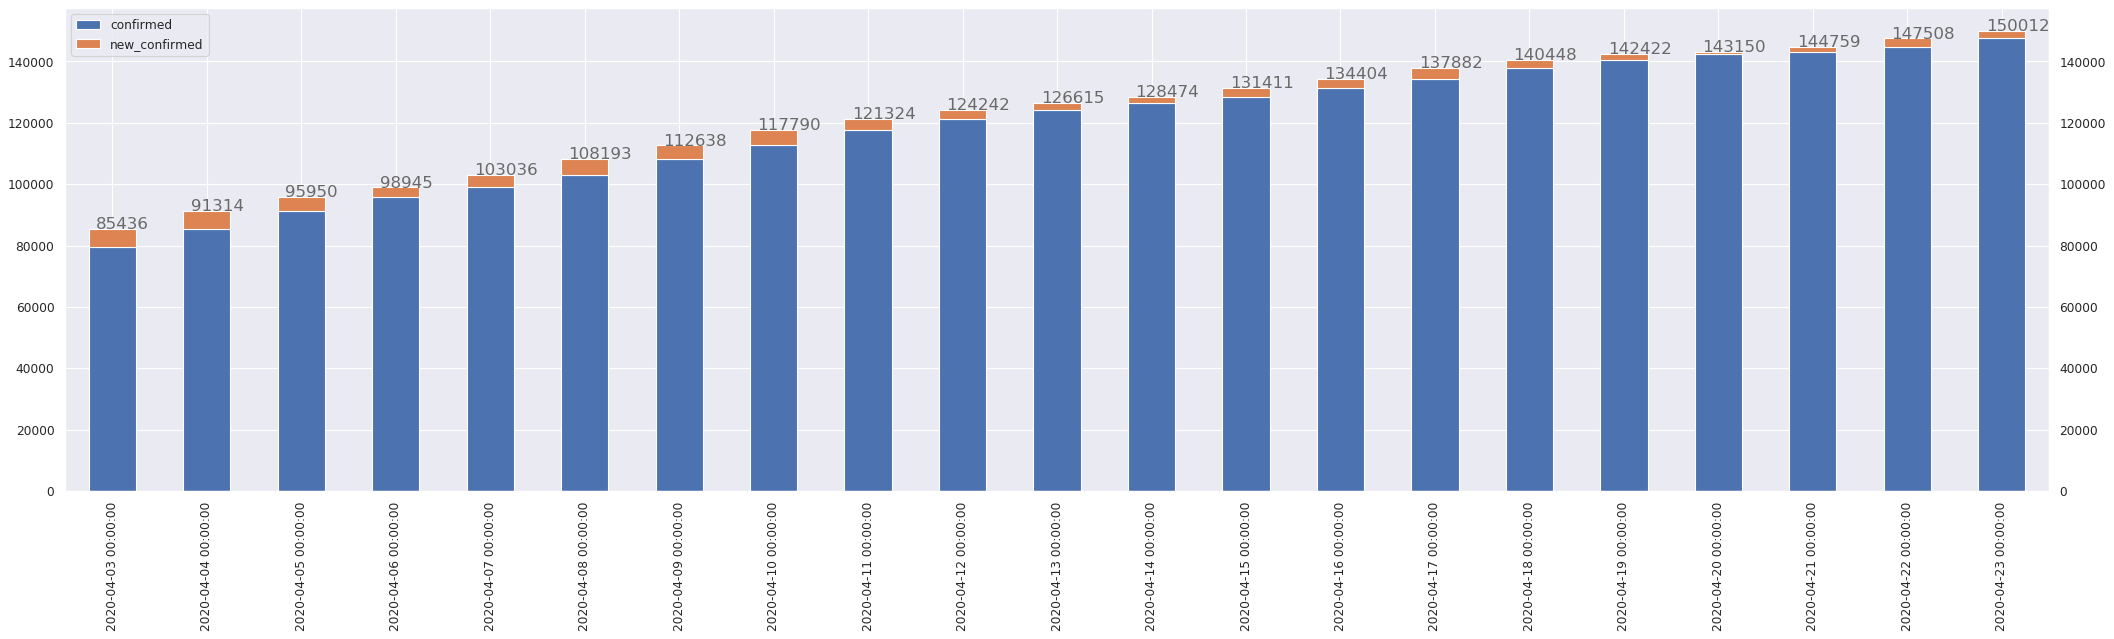

In [23]:
cbr_germany.plot_daily_stacked()

In [24]:
cbr_austria = covid19.CasesByRegion('Austria')
cbr_austria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-19,14824,10631,470,40,130,18
2020-04-20,14880,10971,491,56,340,21
2020-04-21,14942,11328,510,62,357,19
2020-04-22,15005,11694,522,63,366,12
2020-04-23,15051,11872,530,46,178,8


[COVID-19-Pandemie#%C3%96sterreich](https://de.wikipedia.org/wiki/COVID-19-Pandemie#%C3%96sterreich)

> Nachdem Mitte März zuerst einzelne Gemeinden unter Quarantäne gestellt wurden, verlautbarte Bundeskanzler Sebastian Kurz am 15. März eine landesweite Ausgangsbeschränkung, verbunden mit einer Einschränkung der Versammlungsfreiheit auf bis zu fünf Personen.

`2020-03-15`

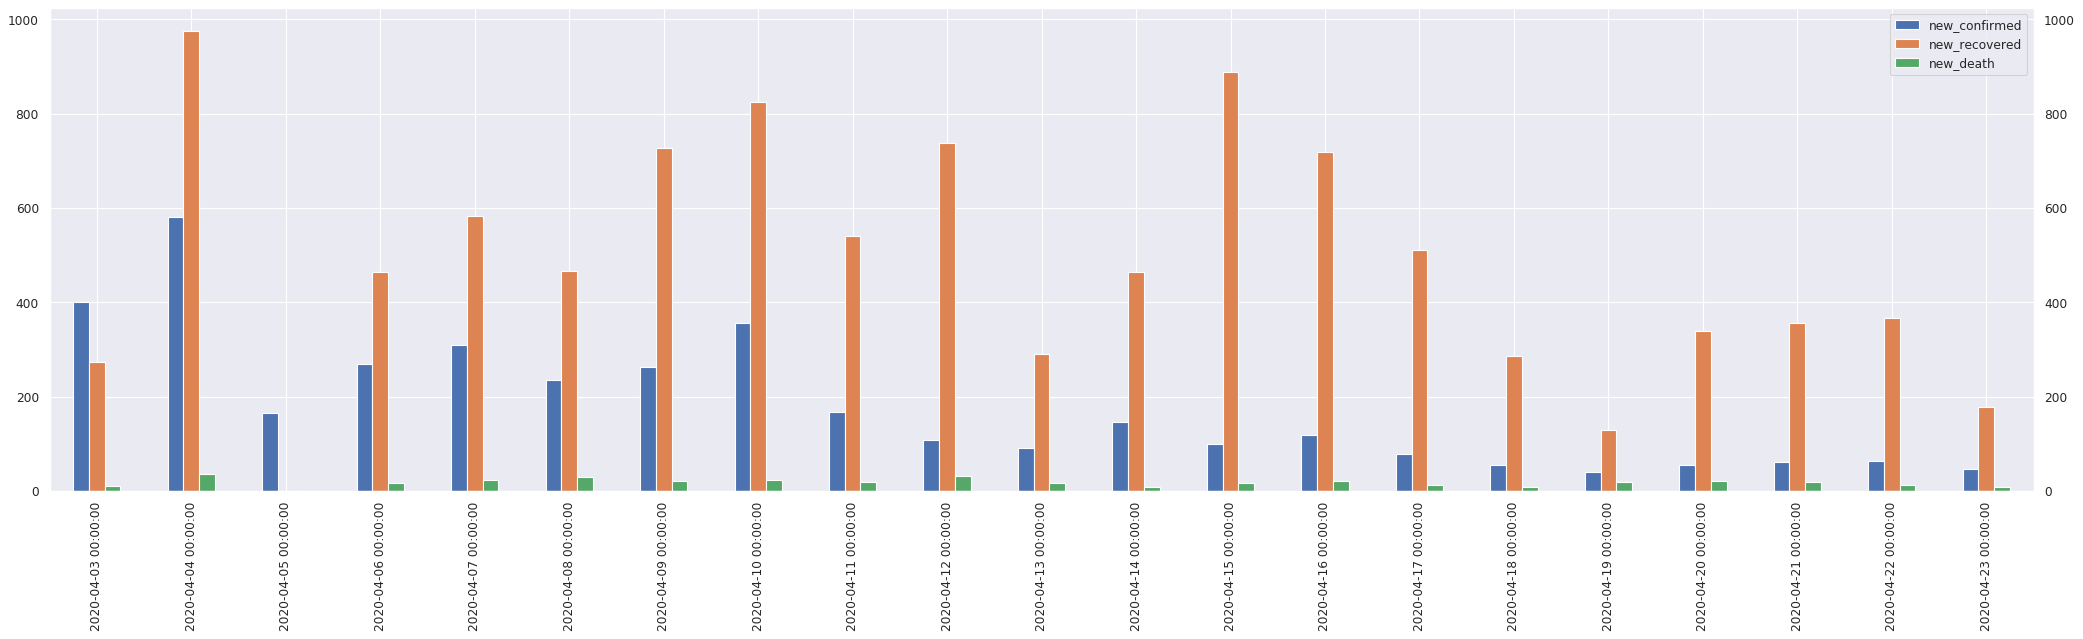

In [25]:
cbr_austria.plot_daily_stats()

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-12 | 13859 | 0.042 | - |
| 2020-04-03 | 2020-04-12 | 13864 | 0.036 | - |
| 2020-04-04 | 2020-04-12 | 14082 | 0.030 | - |
| 2020-04-05 | 2020-04-12 | 13978 | 0.025 | - |
| 2020-04-06 | 2020-04-11 | 13947 | 0.020 | - |
| 2020-04-07 | 2020-04-12 | 14033 | 0.017 | - |
| 2020-04-08 | 2020-04-12 | 14121 | 0.014 | - |
| 2020-04-09 | 2020-04-12 | 14229 | 0.012 | - |
| 2020-04-10 | 2020-04-12 | 14350 | 0.010 | - |
| 2020-04-11 | 2020-04-13 | 14488 | 0.009 | - |
| 2020-04-12 | - | - | 0.012 | 106 |
| 2020-04-13 | - | - | 0.012 | 123 |
| 2020-04-14 | - | - | 0.011 | 126 |
| 2020-04-15 | - | - | 0.010 | 114 |
| 2020-04-15 | - | - | 0.009 | 107 |
| 2020-04-17 | - | - | 0.009 | 106 |
| 2020-04-19 | - | - | 0.007 |  95 |
| 2020-04-20 | - | - | 0.007 |  87 |
| 2020-04-21 | - | - | 0.006 |  83 |
| 2020-04-24 | - | - | 0.005 |  68 |

sigmoid+linear 2020-04-18 00:00:00 [13828.60687661     0.20162984    -2.8520667    338.66710491] 0.004922049832797315 68.28539253102703


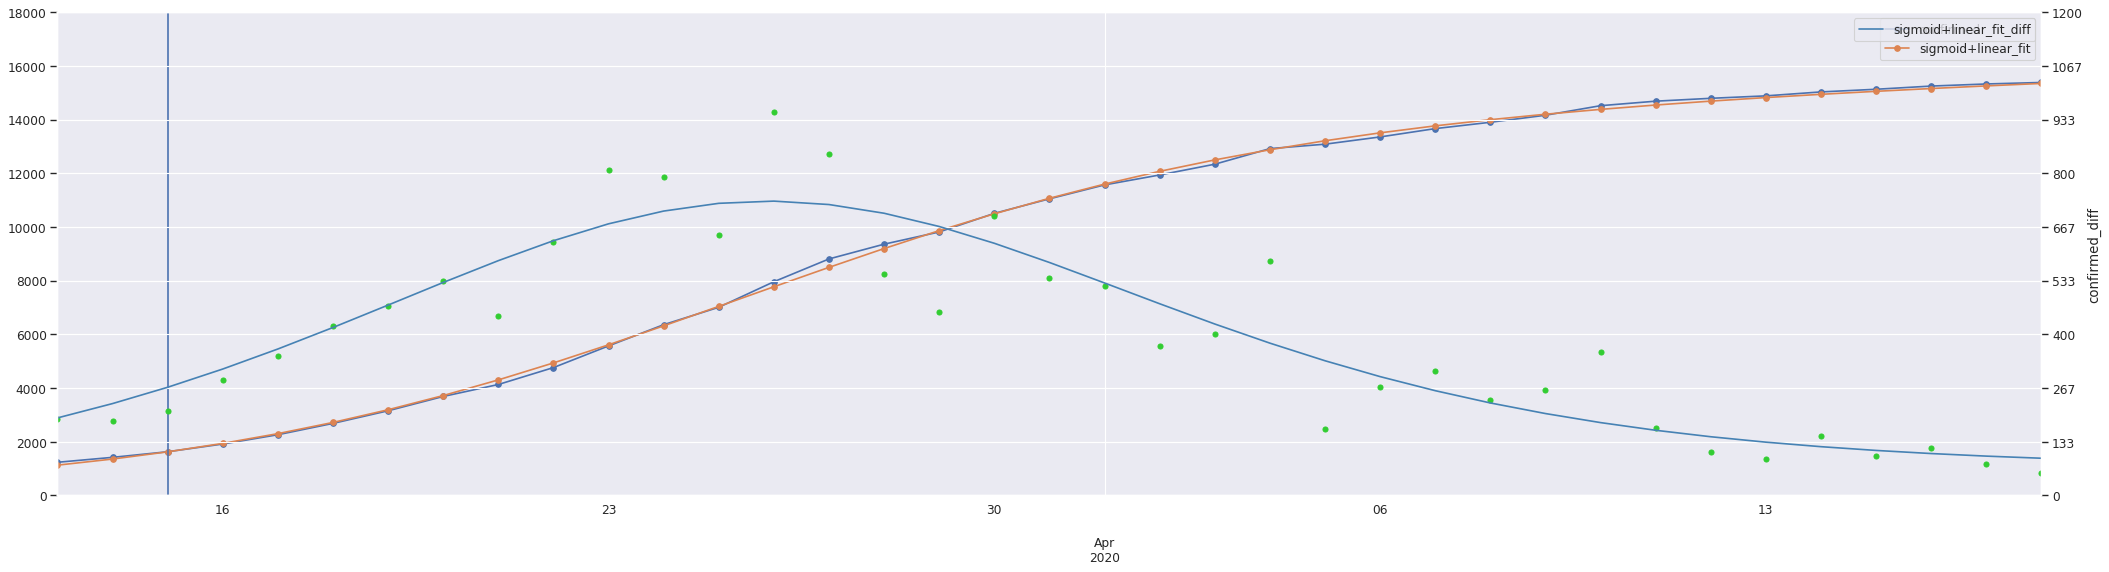

In [26]:
# country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-02-19'), 600, datetime.datetime(2020, 3, 15)
country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-03-12'), 600, datetime.datetime(2020, 3, 15)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')

l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(0.0, e2, l));

In [27]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid+linear_fit_diff
max,730.949244


In [28]:
lds = ldf['confirmed']
idx = lds.index.get_loc(lds.last_valid_index())
lds.iloc[idx] - lds.iloc[idx-1]

56.0

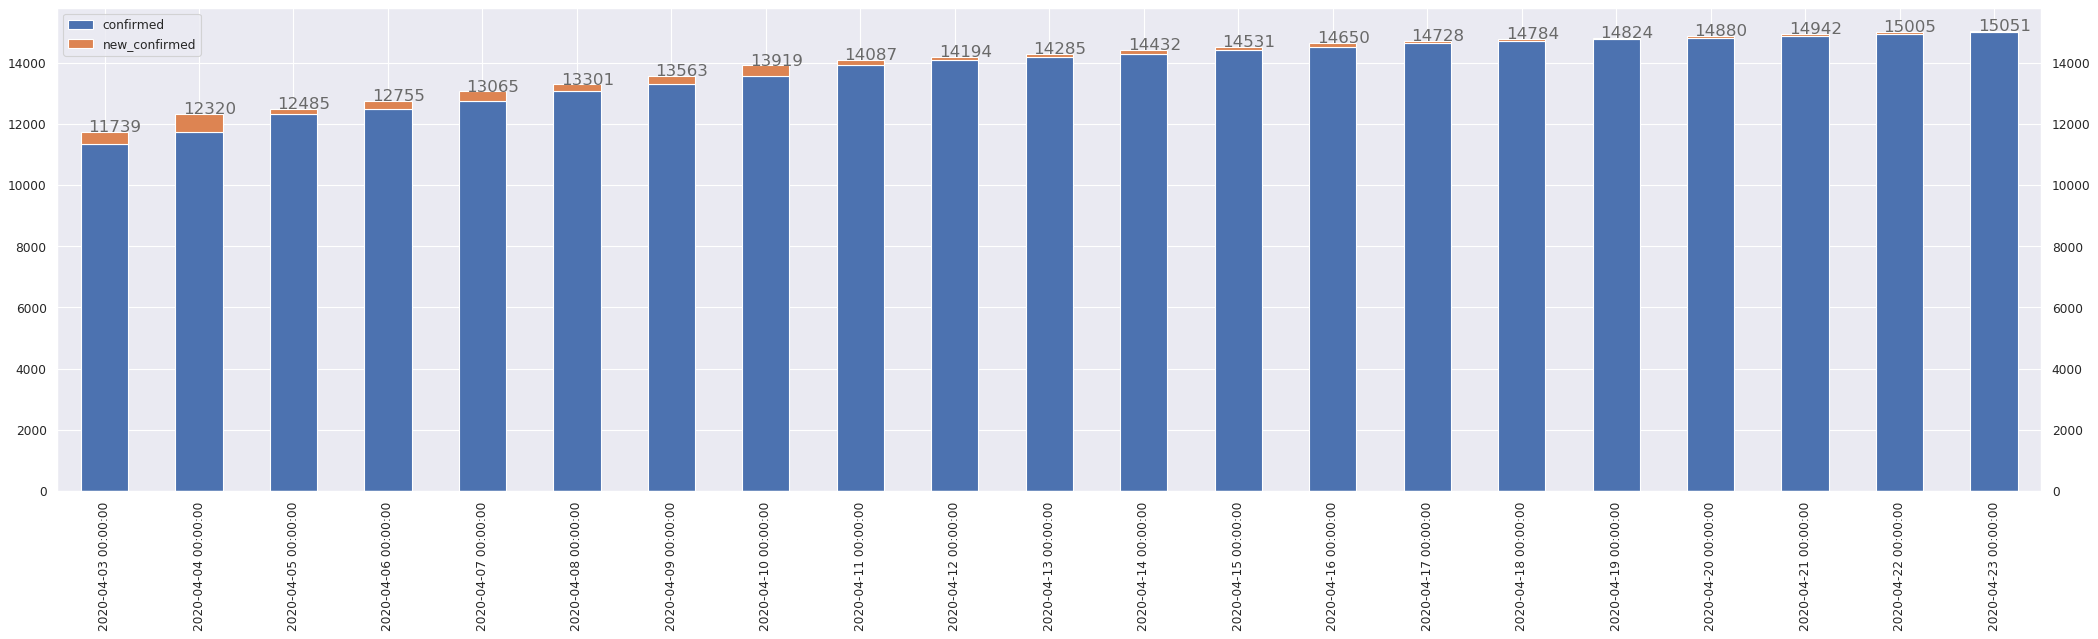

In [29]:
cbr_austria.plot_daily_stacked()

[COVID-19-Pandemie#Dänemark](https://de.wikipedia.org/wiki/COVID-19-Pandemie#D%C3%A4nemark)

> Dänemark hat besonders früh mit strikten Maßnahmen auf die Corona-Krise reagiert, unter anderem sind seit dem 14. März die Grenzen für Ausländer ohne triftigen Einreisegrund geschlossen.

`2020-03-14`

sigmoid 2020-04-26 00:00:00 [9199.42731269    0.11700722   -3.30921723] 0.013869702500173497 0.0


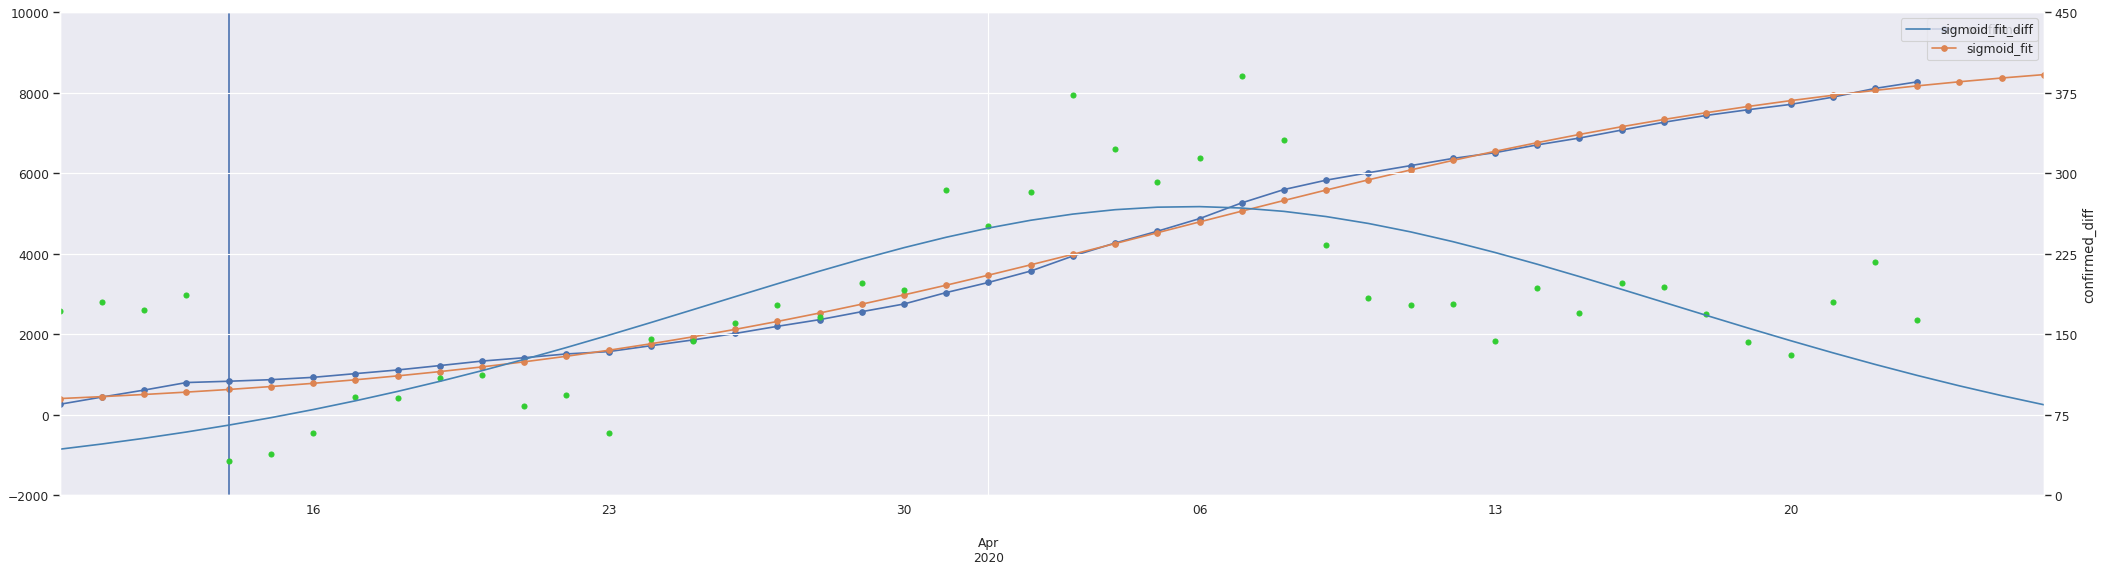

In [30]:
country_name, first_date, init_add, restriction_start_date = 'Denmark', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 14)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')

l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(0.0, e2, l));

In [31]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid_fit_diff
max,268.979474


There are several data issues since 2020-03-12/2020-03-13 in the input data as pointed out here: [Italy has the same number of cases today as they did yesterday.](https://github.com/CSSEGISandData/COVID-19/issues/599)

Also trying to get the raw numbers that [Coronavirus-Monitor](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/?fbclid=IwAR04HlqzakGaNssQzbz4d8o8R3gz0C910U8tvfYlBT6P0lVJJvHfk9uS2rc) is using for Germany from [@datentaeterin](https://twitter.com/datentaeterin/status/1237807179815686144). These numbers seem to be more up-to-date than all the other data-sources.

In [32]:
fname = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
alternative_italy_data = pd.read_csv(fname)
dates = pd.to_datetime(alternative_italy_data['data']).dt.date
alternative_italy_data = alternative_italy_data.rename(columns={"totale_casi": "confirmed", "deceduti": "death", "dimessi_guariti": "recovered"})
alternative_italy_data = alternative_italy_data[['confirmed', 'recovered', 'death']].copy()
for property in ['confirmed', 'recovered', 'death']:
    diff = alternative_italy_data[property].values[1:] - alternative_italy_data[property].values[:-1]
    alternative_italy_data['new_' + property] = np.concatenate([np.array([0]), diff])  
alternative_italy_data.index = dates
alternative_italy_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-04-19,178972,47055,23660,3047,2128,433
2020-04-20,181228,48877,24114,2256,1822,454
2020-04-21,183957,51600,24648,2729,2723,534
2020-04-22,187327,54543,25085,3370,2943,437
2020-04-23,189973,57576,25549,2646,3033,464


In [33]:
cbr_italy = covid19.CasesByRegion('Italy', df=alternative_italy_data)
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-04-19,178972,47055,23660,3047,2128,433
2020-04-20,181228,48877,24114,2256,1822,454
2020-04-21,183957,51600,24648,2729,2723,534
2020-04-22,187327,54543,25085,3370,2943,437
2020-04-23,189973,57576,25549,2646,3033,464


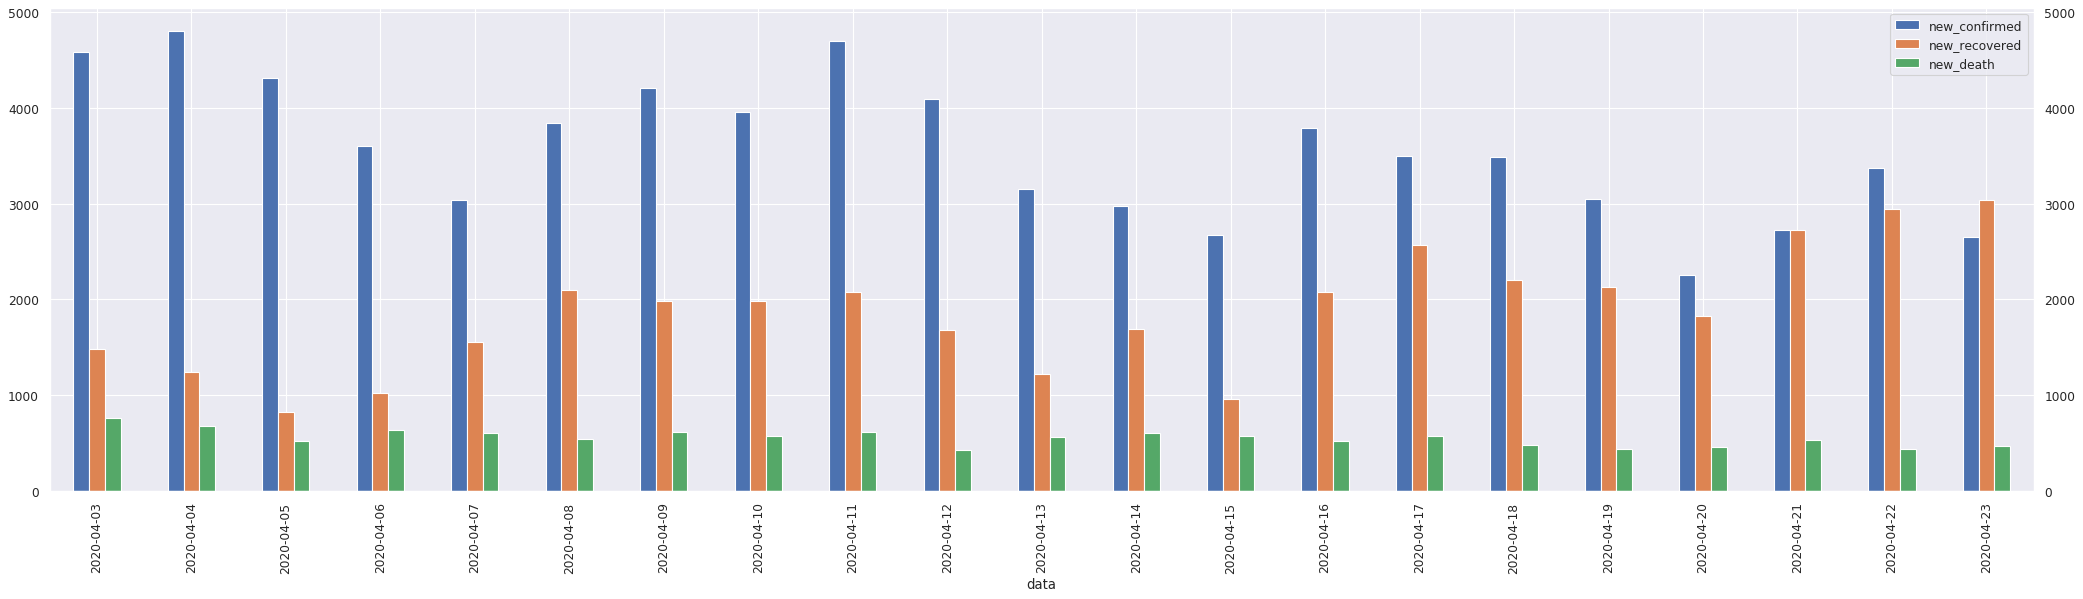

In [34]:
cbr_italy.plot_daily_stats()

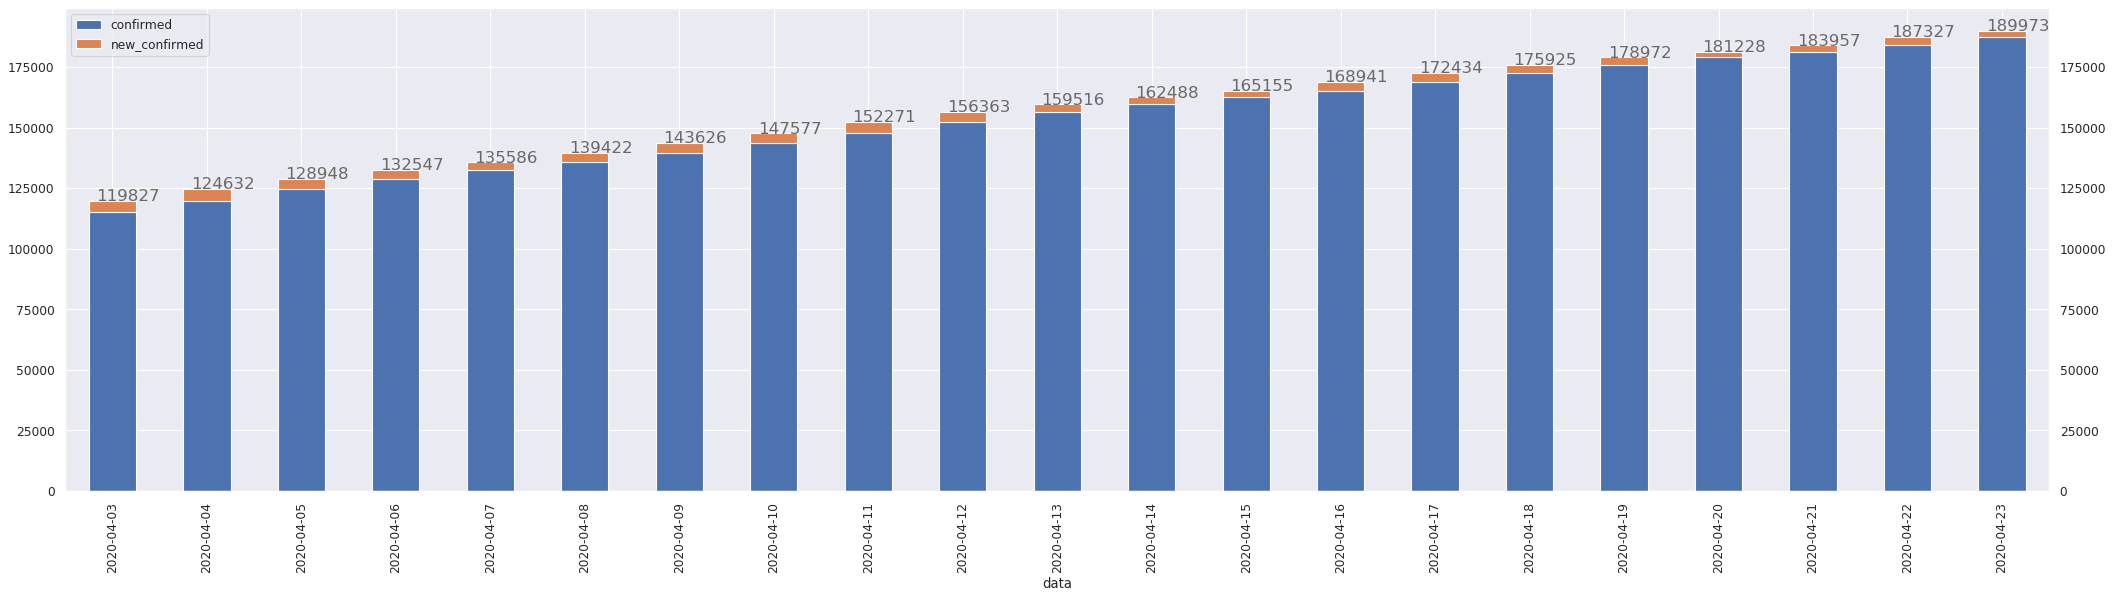

In [35]:
cbr_italy.plot_daily_stacked()

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)


* [mscbs.gob.es](https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/situacionActual.htm)
* https://covid19.isciii.es/
* [github/datadista](https://github.com/datadista/datasets/tree/master/COVID%2019)

In [36]:
fname = 'https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/nacional_covid19.csv'
alternative_spain_data = pd.read_csv(fname)
dates = pd.to_datetime(alternative_spain_data['fecha']).dt.date
alternative_spain_data = alternative_spain_data.rename(columns={"casos": "confirmed", "fallecimientos": "death", "altas": "recovered"})
alternative_spain_data = alternative_spain_data[['confirmed', 'recovered', 'death']].copy()
for property in ['confirmed', 'recovered', 'death']:
    diff = alternative_spain_data[property].values[1:] - alternative_spain_data[property].values[:-1]
    alternative_spain_data['new_' + property] = np.concatenate([np.array([0]), diff])  
alternative_spain_data.index = dates
alternative_spain_data.index.name = 'index'
alternative_spain_data = alternative_spain_data.fillna(0).astype(np.int)
alternative_spain_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-20,200210,80587,20852,4266,3230,399
2020-04-21,204178,82514,21282,3968,1927,430
2020-04-22,208389,85915,21717,4211,3401,435
2020-04-23,213024,89250,22157,4635,3335,440
2020-04-24,219764,92355,22524,6740,3105,367


In [37]:
cbr_spain = covid19.CasesByRegion('Spain', df=alternative_spain_data)
cbr_spain.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-20,200210,80587,20852,4266,3230,399
2020-04-21,204178,82514,21282,3968,1927,430
2020-04-22,208389,85915,21717,4211,3401,435
2020-04-23,213024,89250,22157,4635,3335,440
2020-04-24,219764,92355,22524,6740,3105,367


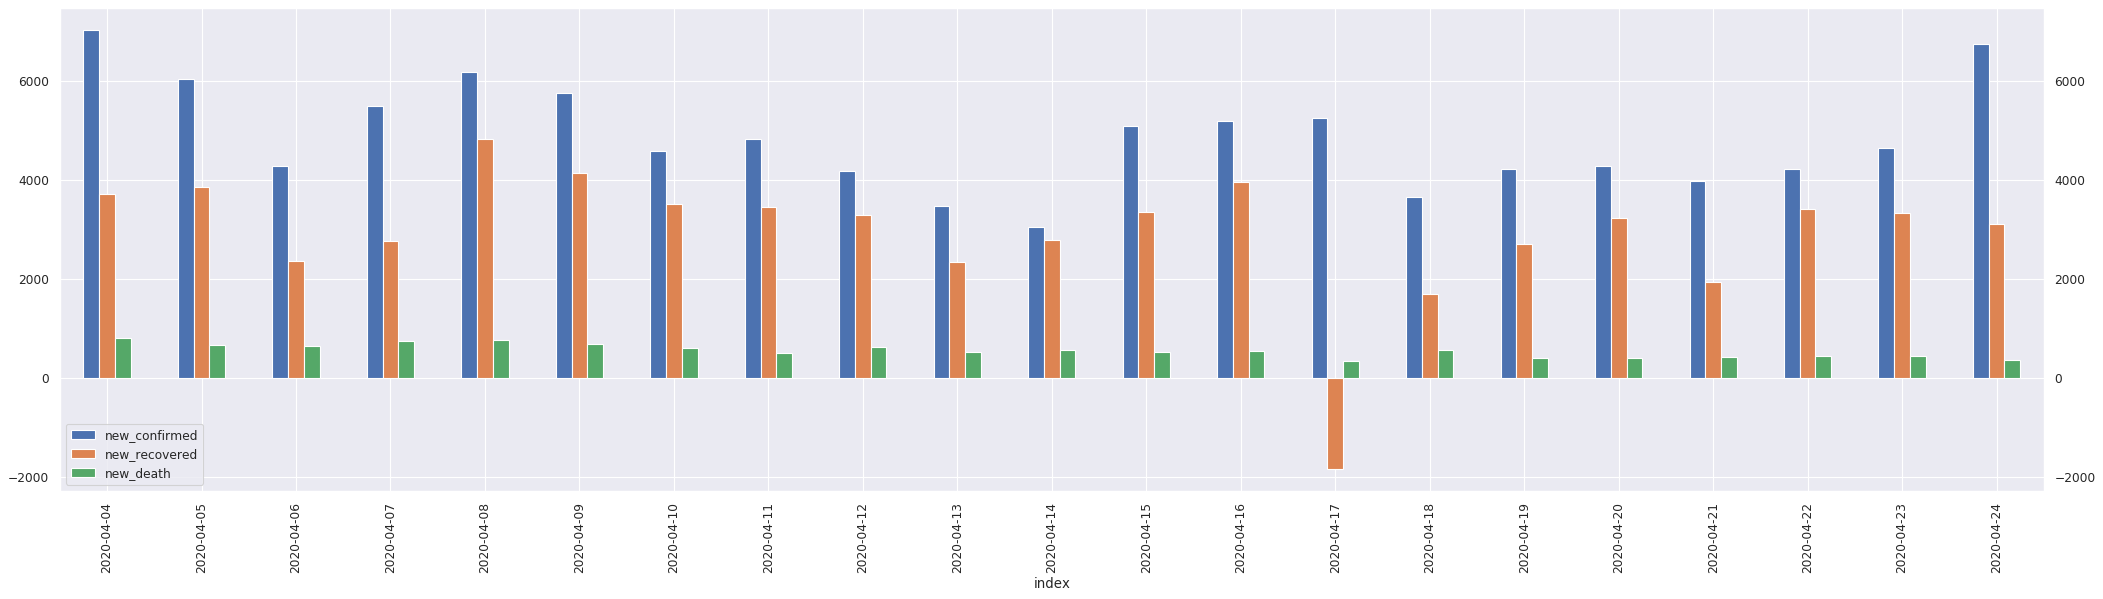

In [38]:
cbr_spain.plot_daily_stats()

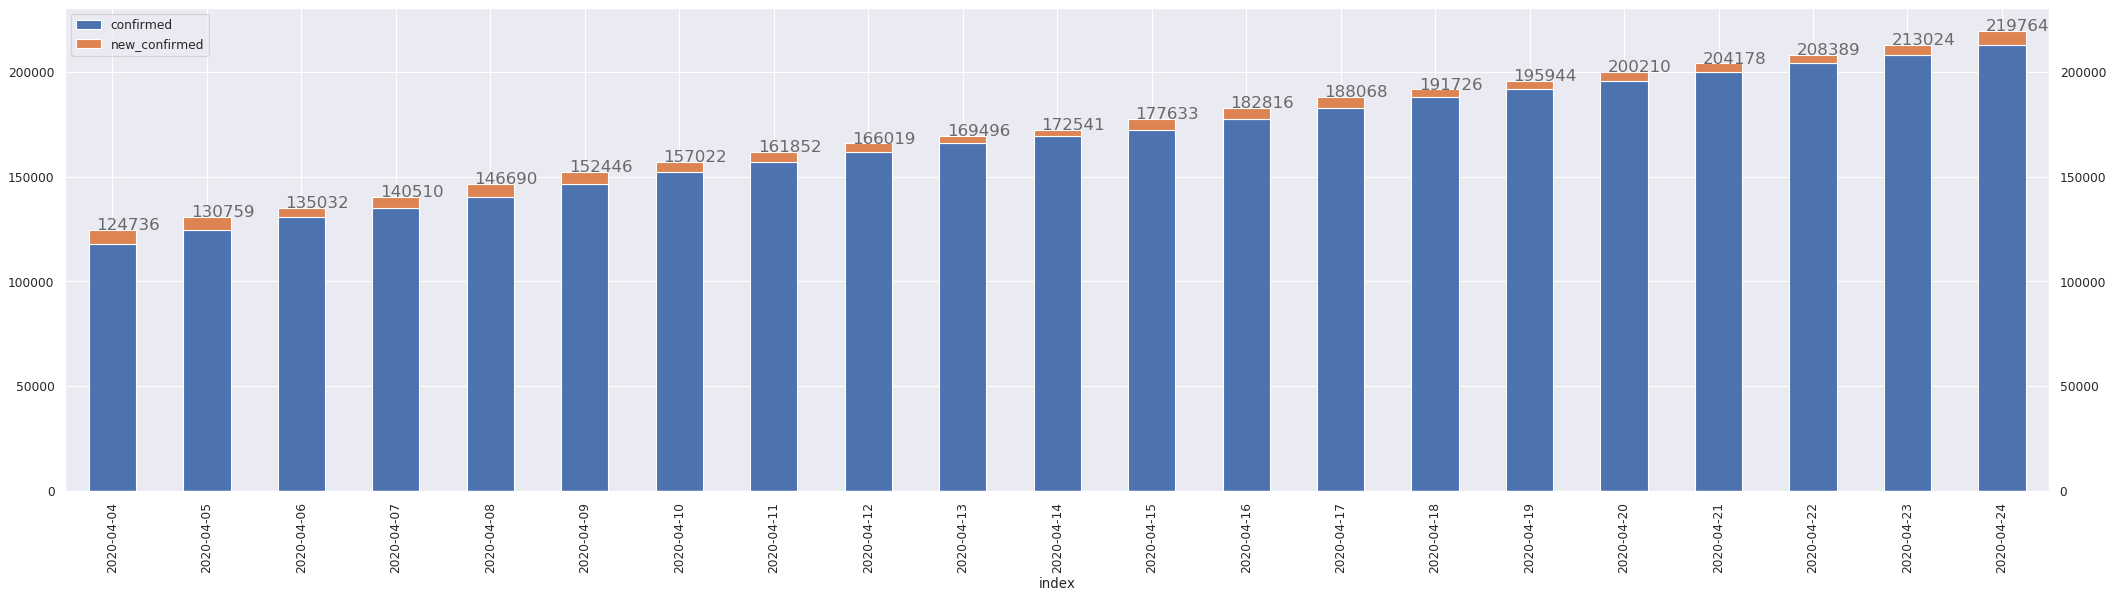

In [39]:
cbr_spain.plot_daily_stacked()

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)



* [opencovid19-fr / data](https://github.com/opencovid19-fr/data/blob/master/README.en.md)
    * [chiffres-cles.csv](https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv)
    * [dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/5e09dff7cb434fb194e22261689e2887)
    * [santepubliquefrance](https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde)

In [40]:
fname = 'https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv'
alternative_france_data = pd.read_csv(fname)
alternative_france_data = alternative_france_data[(alternative_france_data['granularite'] == 'pays') & (alternative_france_data['source_type'] == 'ministere-sante')]
dates = pd.to_datetime(alternative_france_data['date']).dt.date
alternative_france_data = alternative_france_data.rename(columns={"cas_confirmes": "confirmed", "deces": "death", "gueris": "recovered"})
alternative_france_data['death'] += alternative_france_data['deces_ehpad']
alternative_france_data = alternative_france_data[['confirmed', 'recovered', 'death']].copy()
for property in ['confirmed', 'recovered', 'death']:
    diff = alternative_france_data[property].values[1:] - alternative_france_data[property].values[:-1]
    alternative_france_data['new_' + property] = np.concatenate([np.array([0]), diff])  
alternative_france_data.index = dates
alternative_france_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-04-19,112606.0,36578.0,19718.0,785.0,595.0,395.0
2020-04-20,114657.0,37409.0,20265.0,2051.0,831.0,547.0
2020-04-21,117324.0,39181.0,20796.0,2667.0,1772.0,531.0
2020-04-22,119151.0,40657.0,21340.0,1827.0,1476.0,544.0
2020-04-23,120804.0,42088.0,21856.0,1653.0,1431.0,516.0


In [41]:
cbr_france = covid19.CasesByRegion('France', df=alternative_france_data)
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-04-19,112606.0,36578.0,19718.0,785.0,595.0,395.0
2020-04-20,114657.0,37409.0,20265.0,2051.0,831.0,547.0
2020-04-21,117324.0,39181.0,20796.0,2667.0,1772.0,531.0
2020-04-22,119151.0,40657.0,21340.0,1827.0,1476.0,544.0
2020-04-23,120804.0,42088.0,21856.0,1653.0,1431.0,516.0


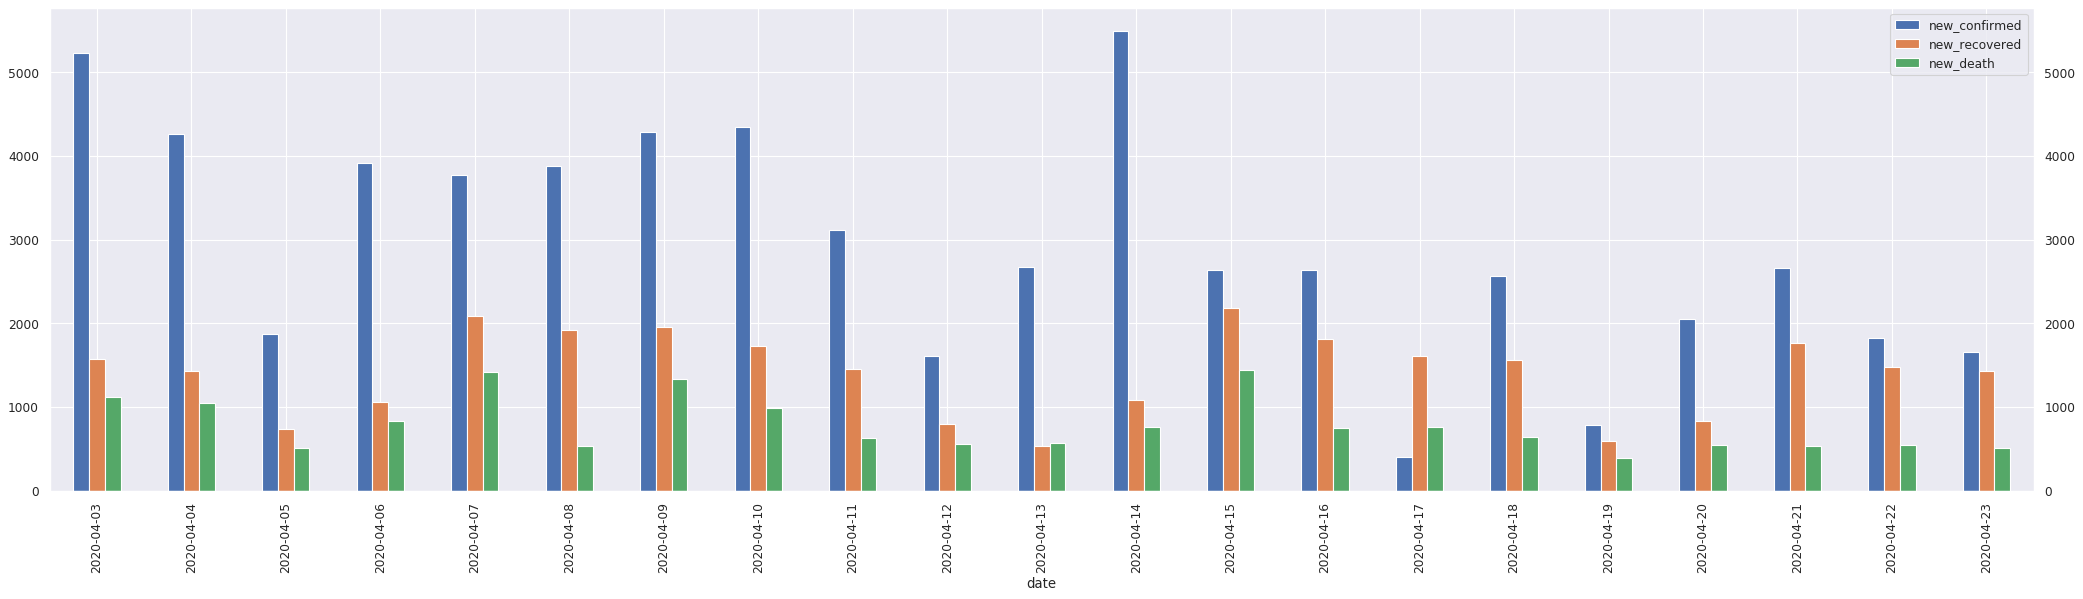

In [42]:
cbr_france.plot_daily_stats()

In [43]:
# cbr_france.df.to_excel('2020-04-17-france.xlsx')

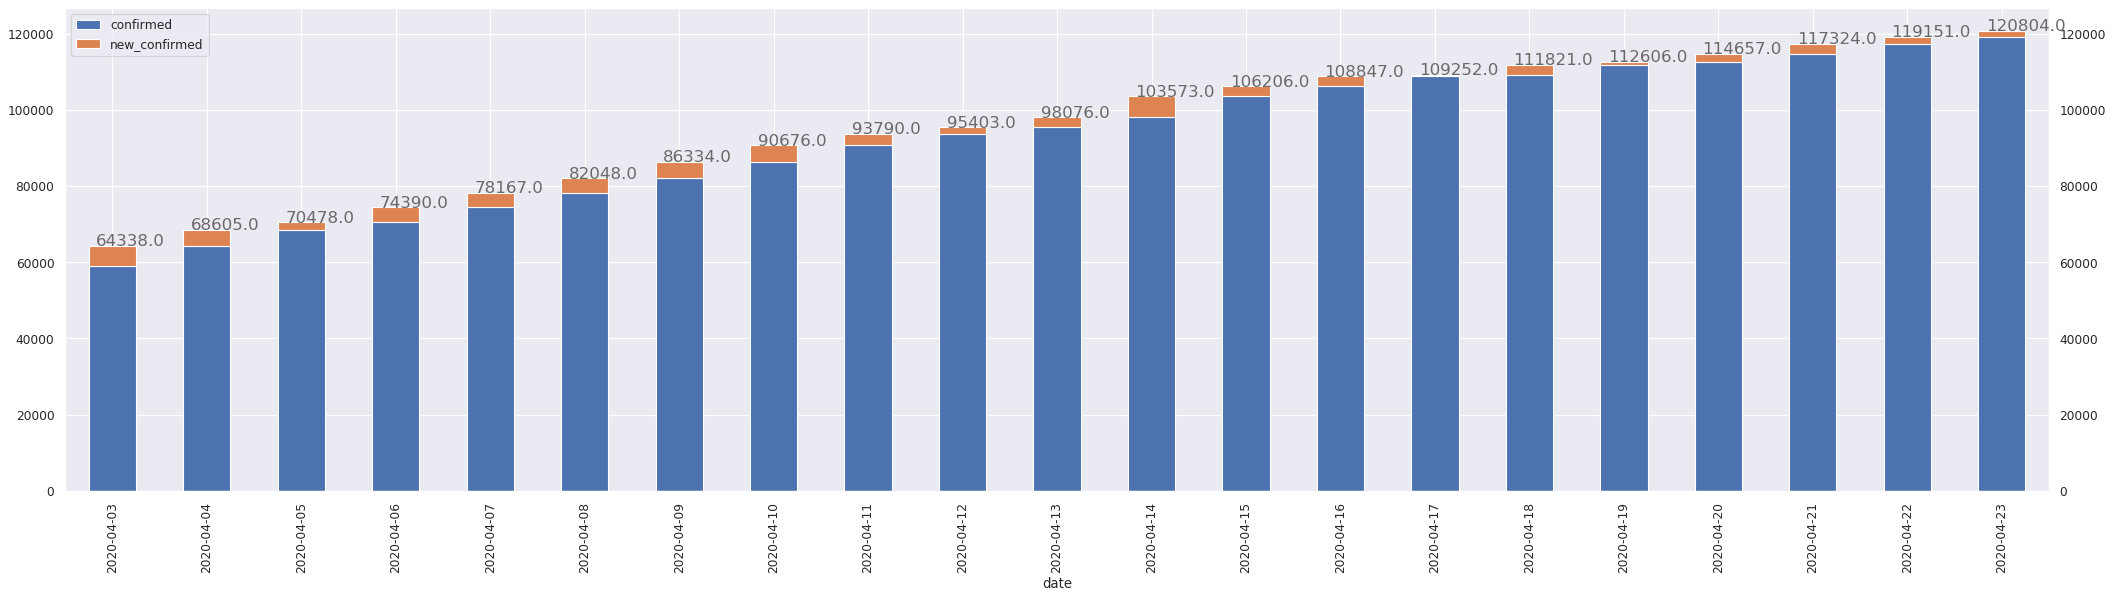

In [44]:
cbr_france.plot_daily_stacked()

In [45]:
cbr_south_korea = covid19.CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-19,10661,8042,234,8,105,2
2020-04-20,10674,8114,236,13,72,2
2020-04-21,10683,8213,237,9,99,1
2020-04-22,10694,8277,238,11,64,1
2020-04-23,10708,8501,240,14,224,2


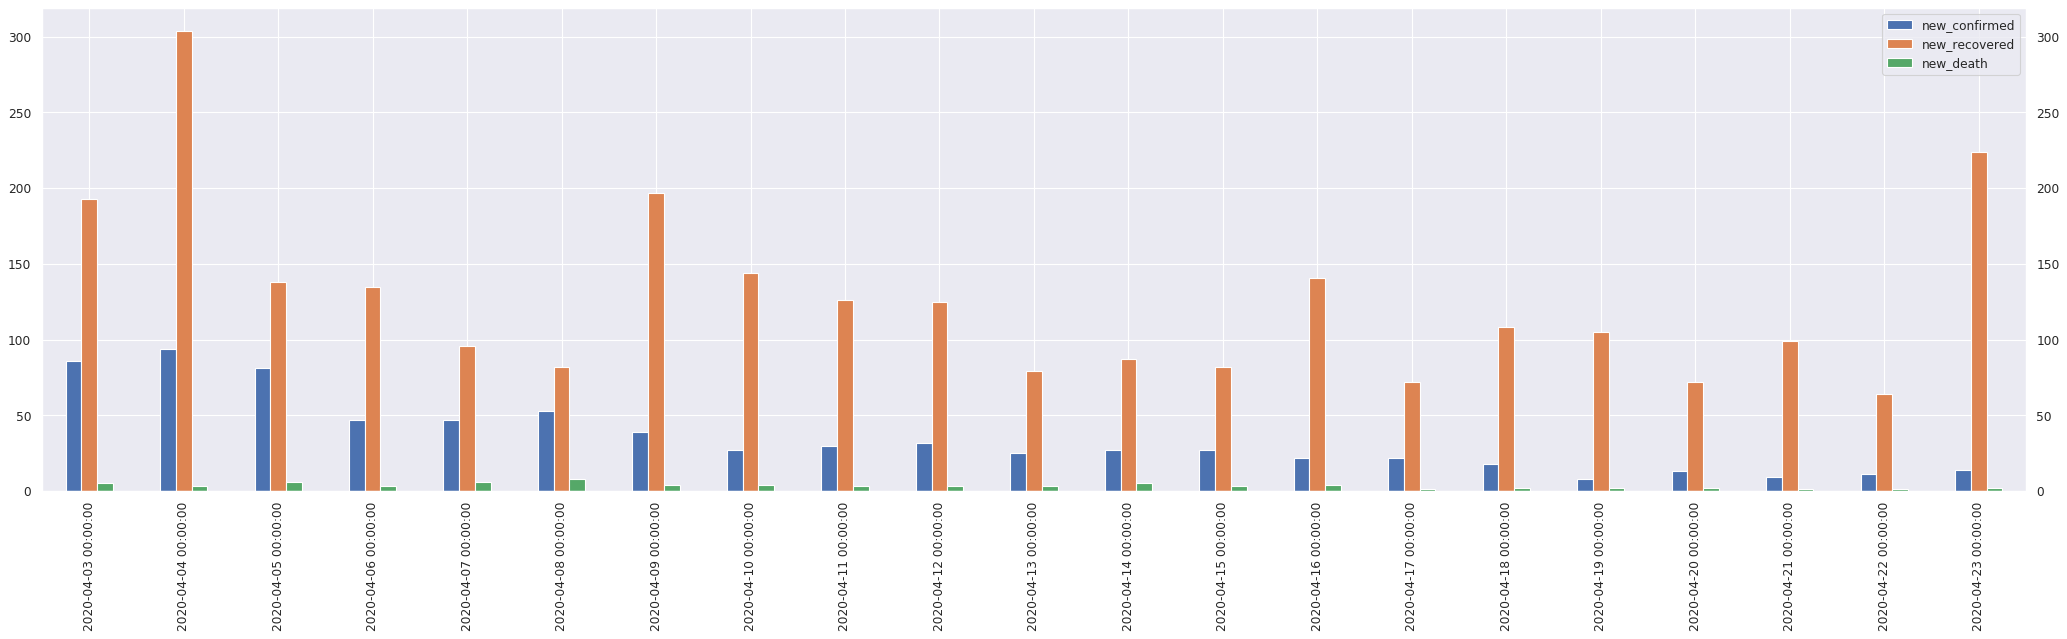

In [46]:
cbr_south_korea.plot_daily_stats()

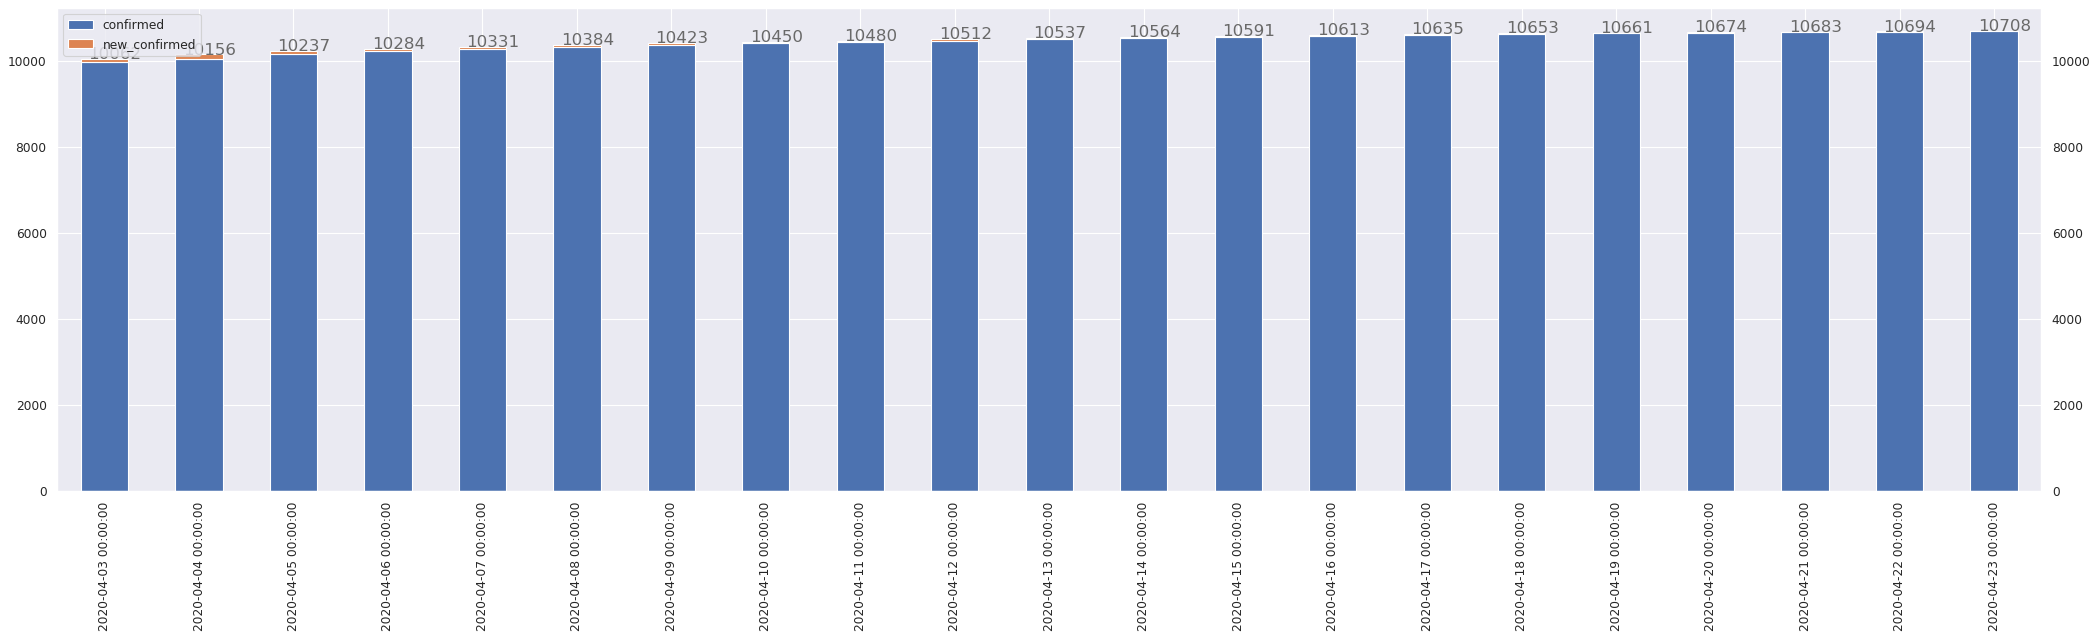

In [47]:
cbr_south_korea.plot_daily_stacked()

In [48]:
cbr_uk = covid19.CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-19,121172,436,16095,5858,22,597
2020-04-20,125856,446,16550,4684,10,455
2020-04-21,130172,638,17378,4316,192,828
2020-04-22,134638,683,18151,4466,45,773
2020-04-23,139246,712,18791,4608,29,640


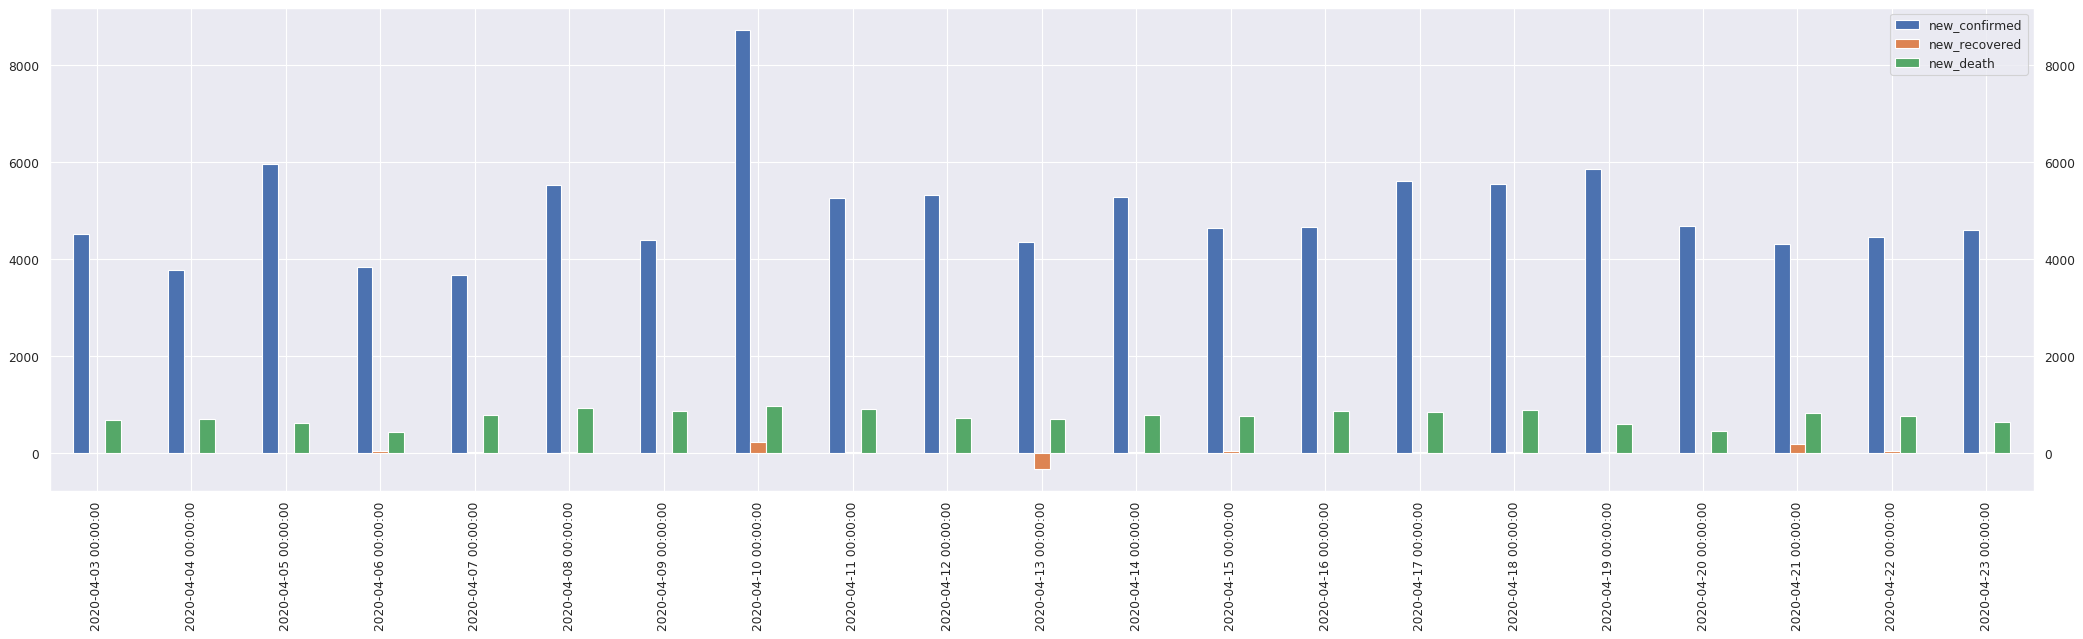

In [49]:
cbr_uk.plot_daily_stats()

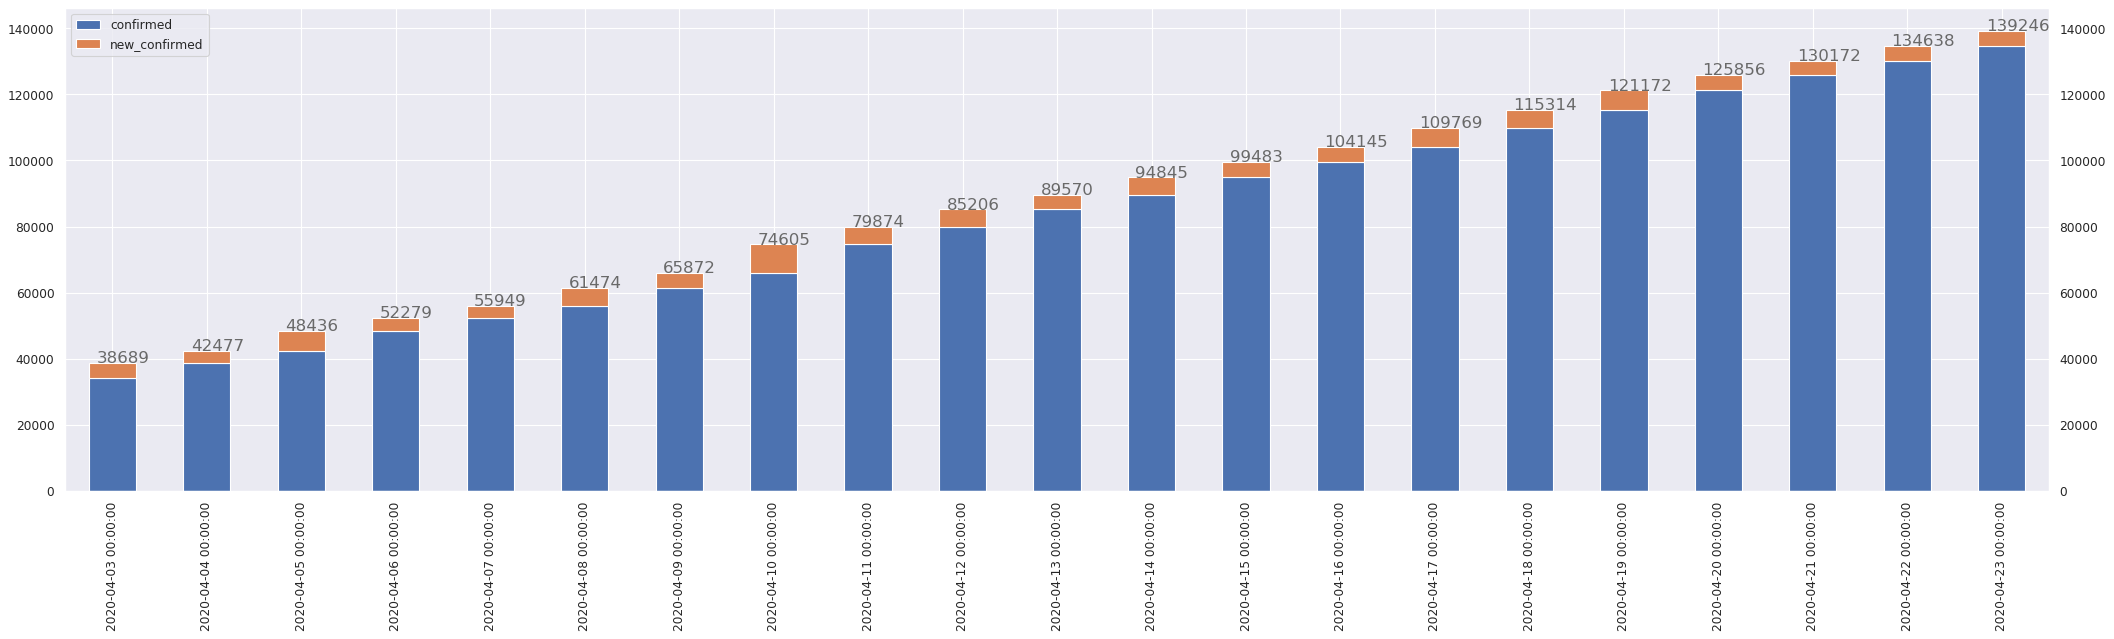

In [50]:
cbr_uk.plot_daily_stacked()

In [51]:
cbr_us = covid19.CasesByRegion('US')
cbr_us.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-19,758809,70337,40661,26612,5497,1997
2020-04-20,784326,72329,42094,25517,1992,1433
2020-04-21,811865,75204,44444,27539,2875,2350
2020-04-22,840351,77366,46622,28486,2162,2178
2020-04-23,869170,80203,49954,28819,2837,3332


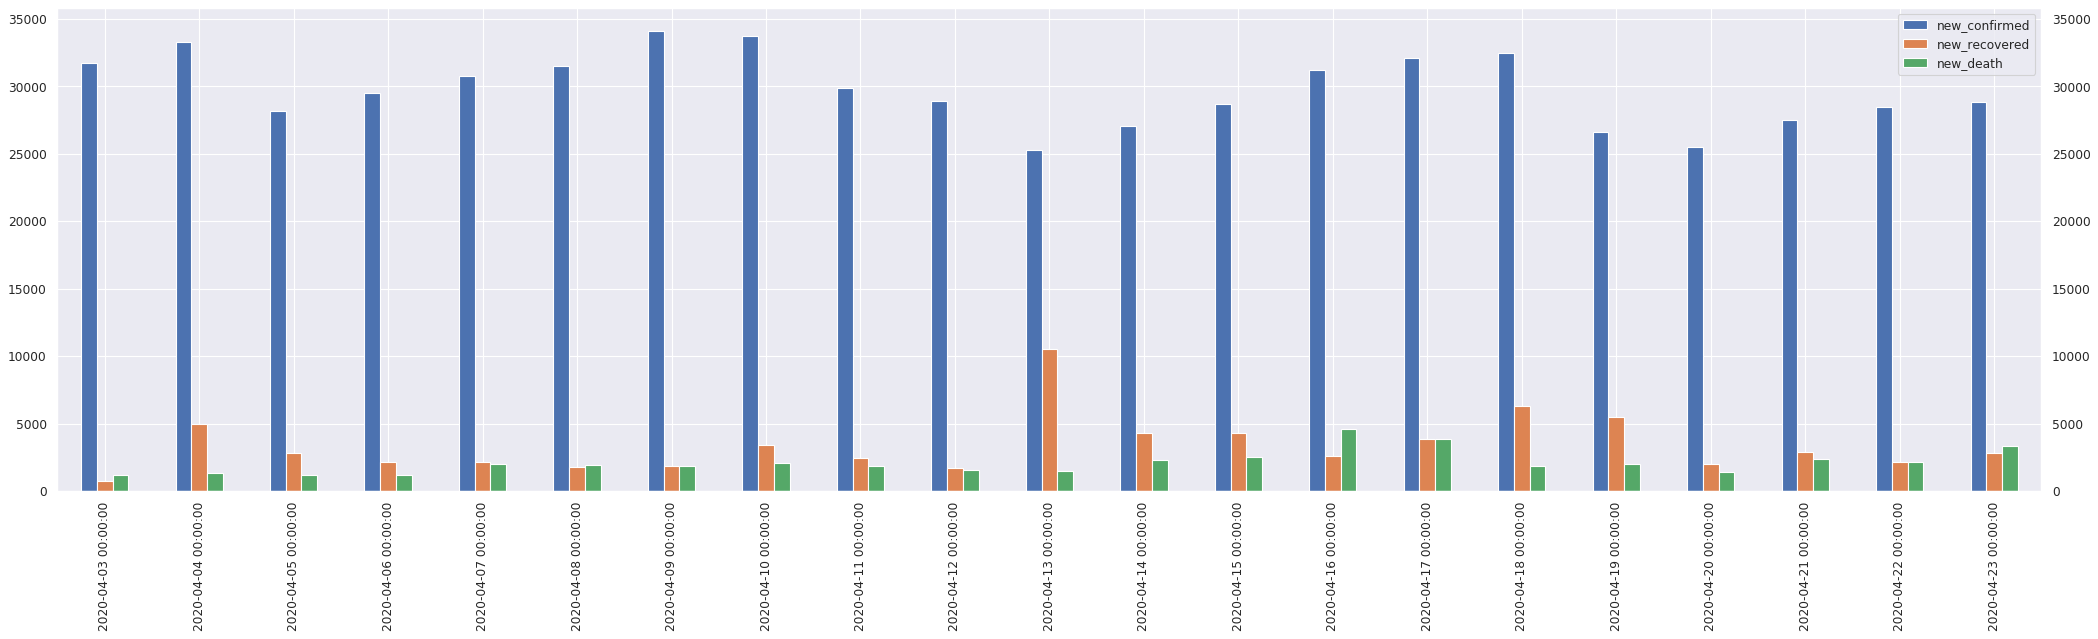

In [52]:
cbr_us.plot_daily_stats()

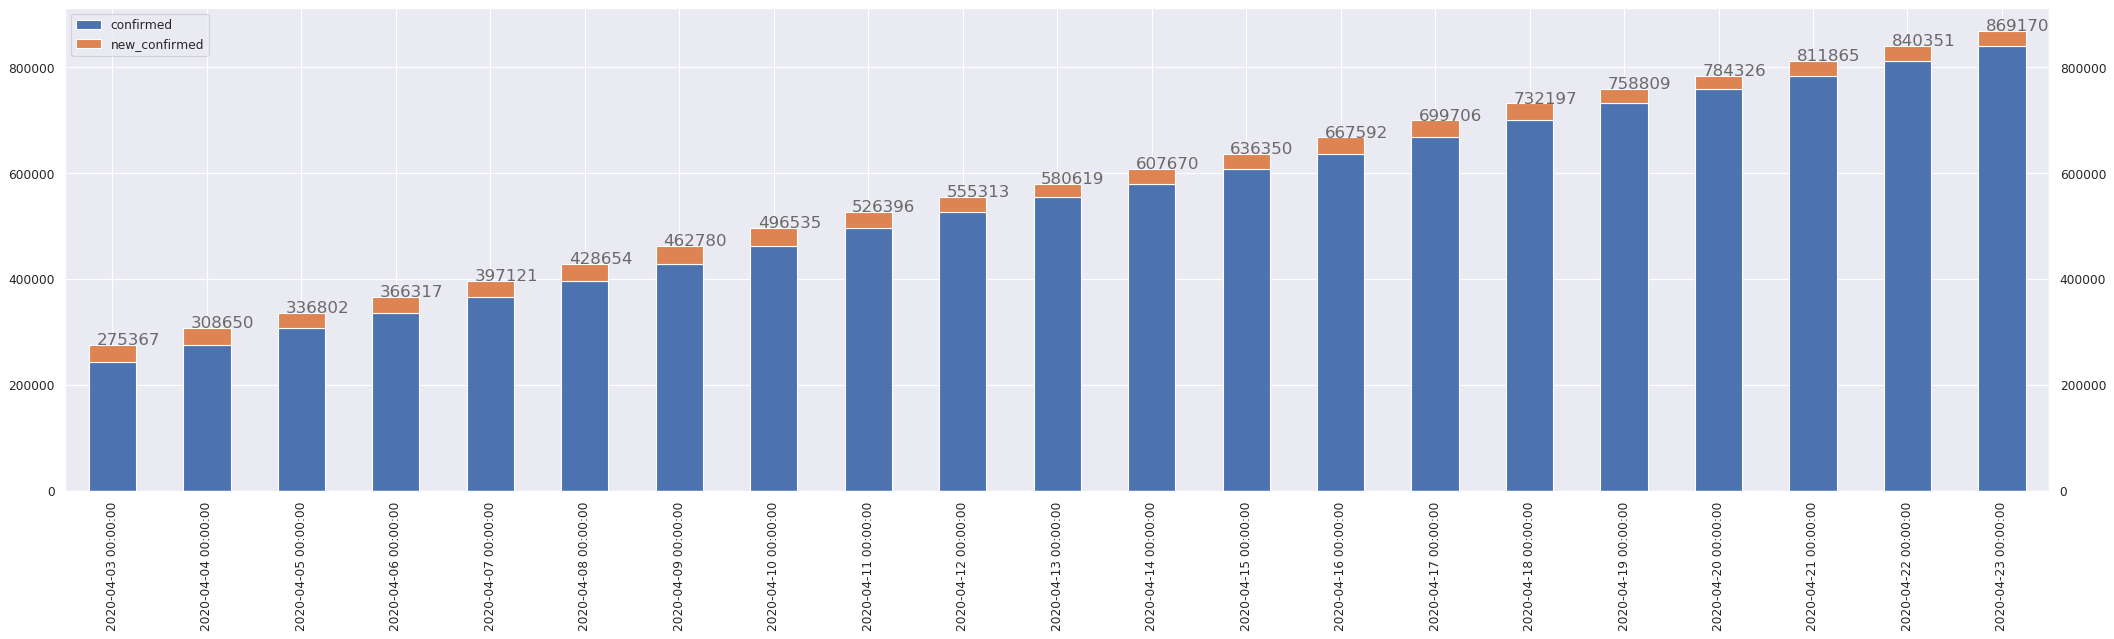

In [53]:
cbr_us.plot_daily_stacked()

In [54]:
cbr_switzerland = covid19.CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-19,27740,17800,1393,336,700,25
2020-04-20,27944,18600,1429,204,800,36
2020-04-21,28063,19400,1478,119,800,49
2020-04-22,28268,19900,1509,205,500,31
2020-04-23,28496,20600,1549,228,700,40


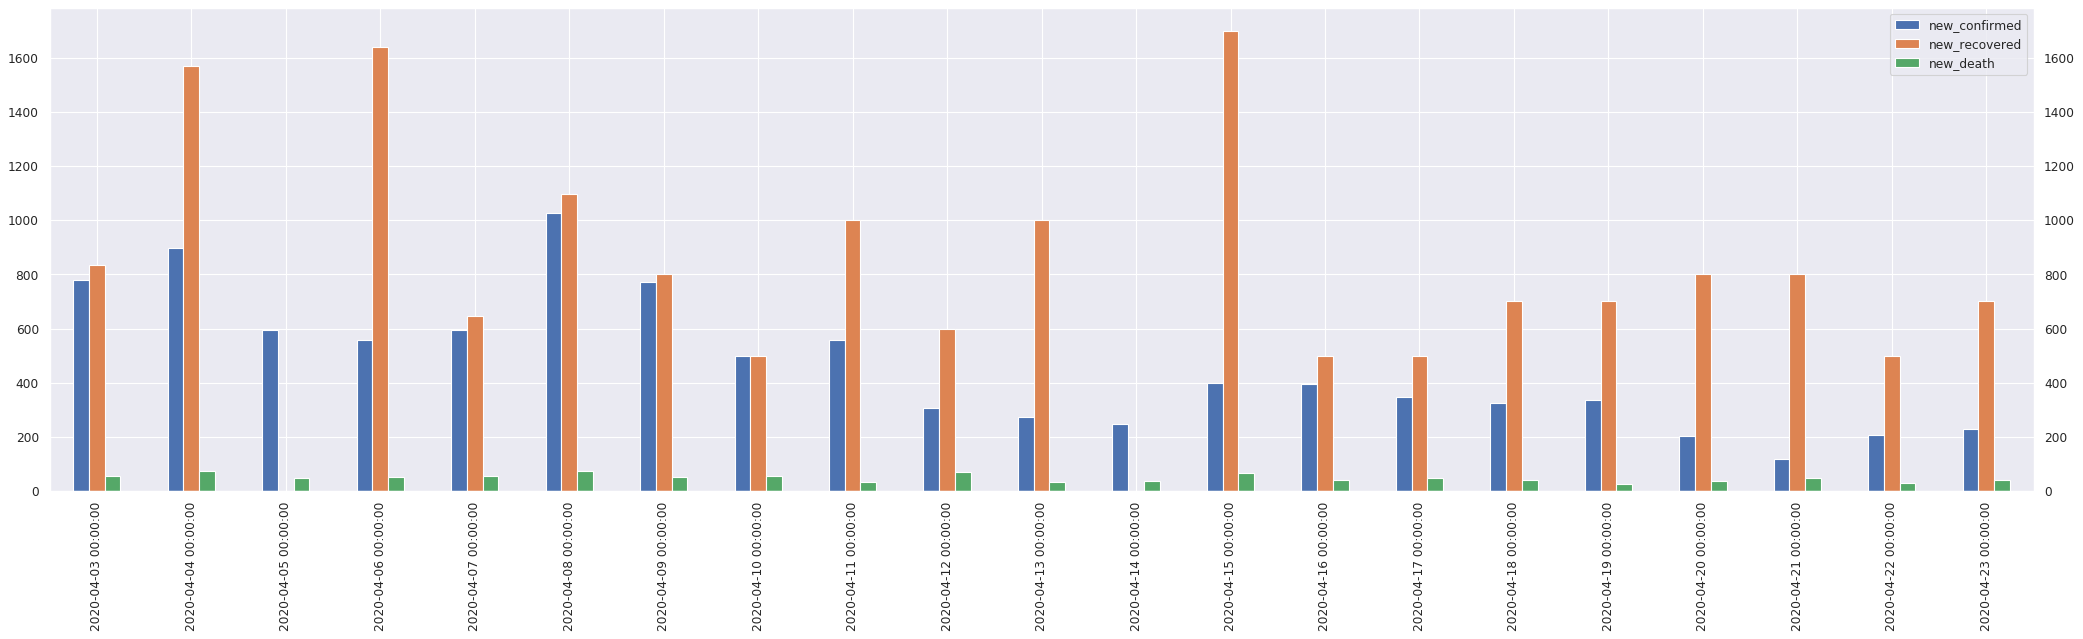

In [55]:
cbr_switzerland.plot_daily_stats()

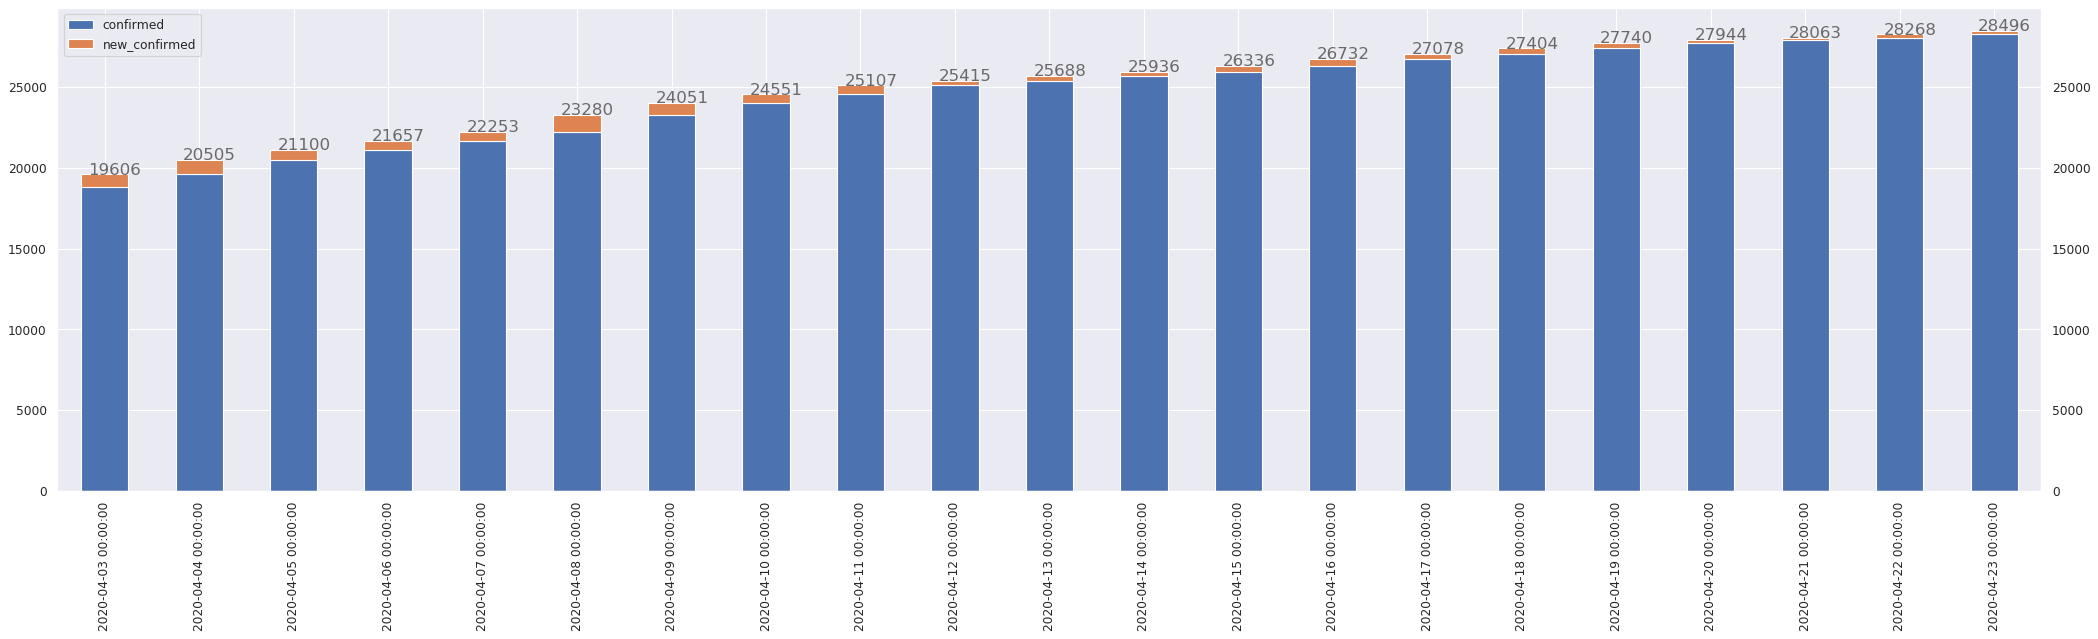

In [56]:
cbr_switzerland.plot_daily_stacked()

In [57]:
df_co = covid19.get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-04-23,,,,,
Nicaragua,11,7,3,27.272727,27.272727
MS Zaandam,9,0,2,22.222222,66.666667
Bahamas,72,14,11,15.277778,42.307692
Belgium,42797,9800,6490,15.164614,39.837947
Mauritania,7,6,1,14.285714,12.500000


In [62]:
df_co[df_co.confirmed > 6500].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-04-23,,,,,
Belgium,42797,9800,6490,15.2,39.8
France,159460,42762,21889,13.7,33.9
United Kingdom,139246,712,18791,13.5,96.3
Italy,189973,57576,25549,13.4,30.7
Sweden,16755,550,2021,12.1,78.6
Netherlands,35921,101,4192,11.7,97.6
Spain,213024,89250,22157,10.4,19.9
Mexico,11633,2627,1069,9.2,28.9
Indonesia,7775,960,647,8.3,40.2
